<a href="https://colab.research.google.com/github/gladysadyaz/Hybrid-Method/blob/main/Hybrid_VARX_LSTMRAYA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Input Data**

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
from sklearn.metrics import mean_absolute_percentage_error
from google.colab import drive

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Colab Notebooks"
file_path = "/content/drive/My Drive/Colab Notebooks/wisman bali-kurs (1).xlsx"
df = pd.read_excel(file_path, sheet_name='Sheet1')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
print(df.head())

Mounted at /content/drive
'Copy of BBCA LSTM'	       Untitled0.ipynb
'Hybrid VARX_LSTMGAB.ipynb'    VAR_YT.ipynb
'Hybrid VARX_LSTMNAS.ipynb'   'wisman bali-kurs (1).xlsx'
'Hybrid VARX_LSTMRAYA.ipynb'  'wisman bali-kurs.xlsx'
'nyoba var-lstm.ipynb'
             Kurs  Wisman Bali  Hari Raya
Date                                     
2023-01-01  15592        10626          1
2023-01-02  15572        12338          1
2023-01-03  15590        12122          1
2023-01-04  15615        11957          1
2023-01-05  15610        13463          1


## **Praproses Data**

Normalisasi (Min-Max Scalling)

In [40]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Raya']

scaler = MinMaxScaler()
df_norm = df.copy()
df_norm[endog_vars] = scaler.fit_transform(df[endog_vars]) # Normalisasi hanya untuk variabel endogen
print(df_norm.head())


                Kurs  Wisman Bali  Hari Raya
Date                                        
2023-01-01  0.525739     0.440566          1
2023-01-02  0.514786     0.511547          1
2023-01-03  0.524644     0.502591          1
2023-01-04  0.538335     0.495750          1
2023-01-05  0.535597     0.558191          1


In [41]:
print("Min-Max Data Sebelum Normalisasi:")
print(df[endog_vars].min(), df[endog_vars].max())

print("\nMin-Max Data Setelah Normalisasi:")
print(df_norm[endog_vars].min(), df_norm[endog_vars].max())

Min-Max Data Sebelum Normalisasi:
Kurs           14632
Wisman Bali        0
dtype: int64 Kurs           16458
Wisman Bali    24119
dtype: int64

Min-Max Data Setelah Normalisasi:
Kurs           0.0
Wisman Bali    0.0
dtype: float64 Kurs           1.0
Wisman Bali    1.0
dtype: float64


## **Eksplorasi Data**

**Plot Data**

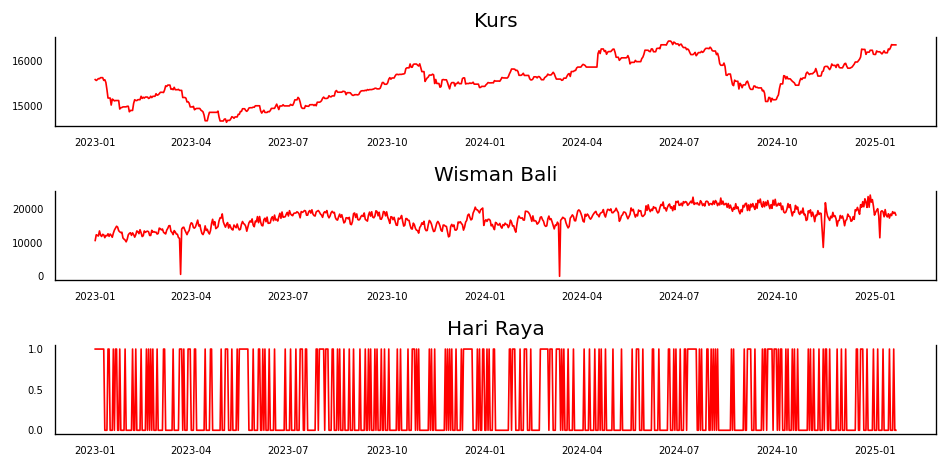

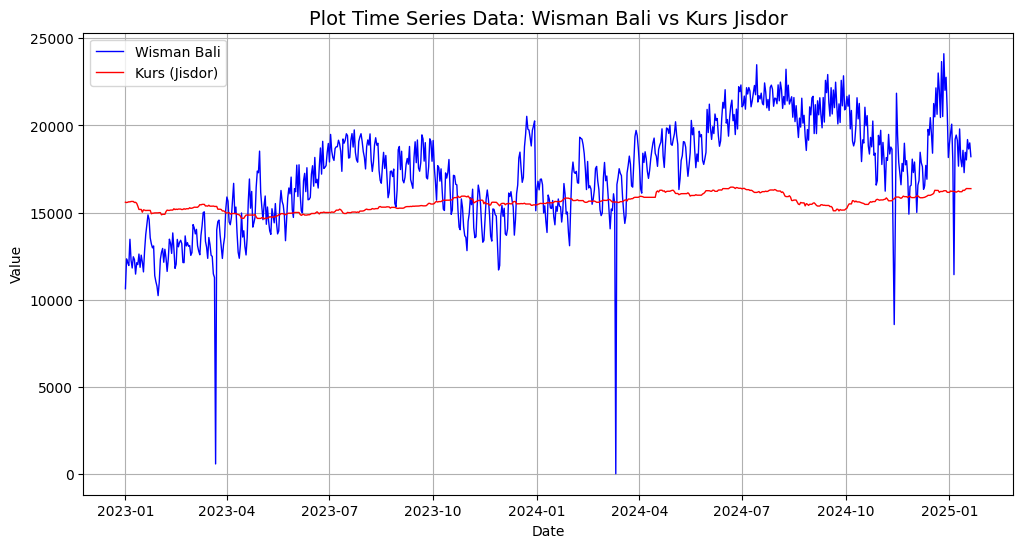

In [42]:
fig, axes = plt.subplots(nrows=3, dpi=120, figsize=(8, 4))

for i, ax in enumerate(axes):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)

    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df['Wisman Bali'], color='blue', linewidth=1, label='Wisman Bali')
plt.plot(df['Kurs'], color='red', linewidth=1, label='Kurs (Jisdor)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Plot Time Series Data: Wisman Bali vs Kurs Jisdor', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


**Trend and Seasonal Plot**

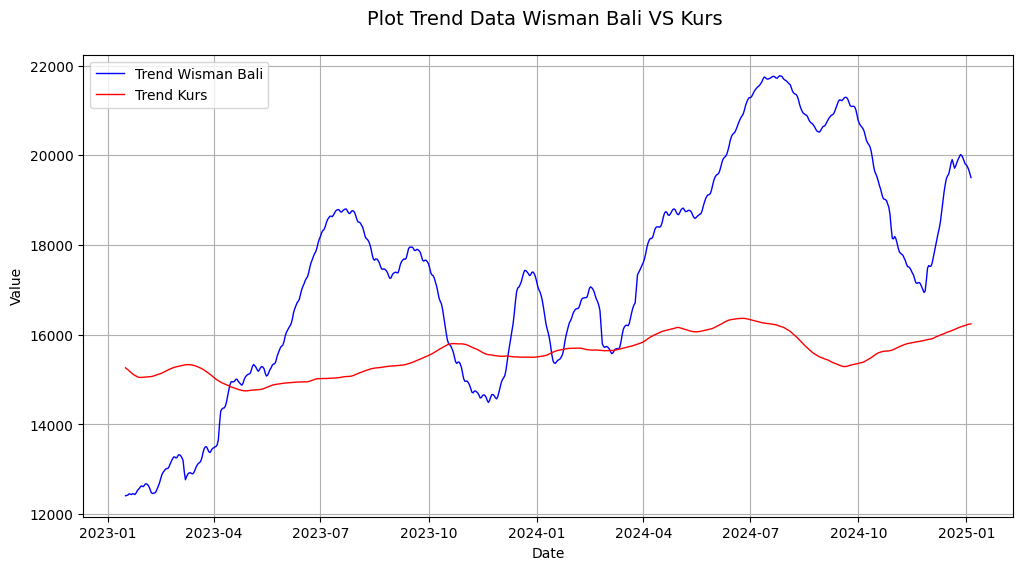

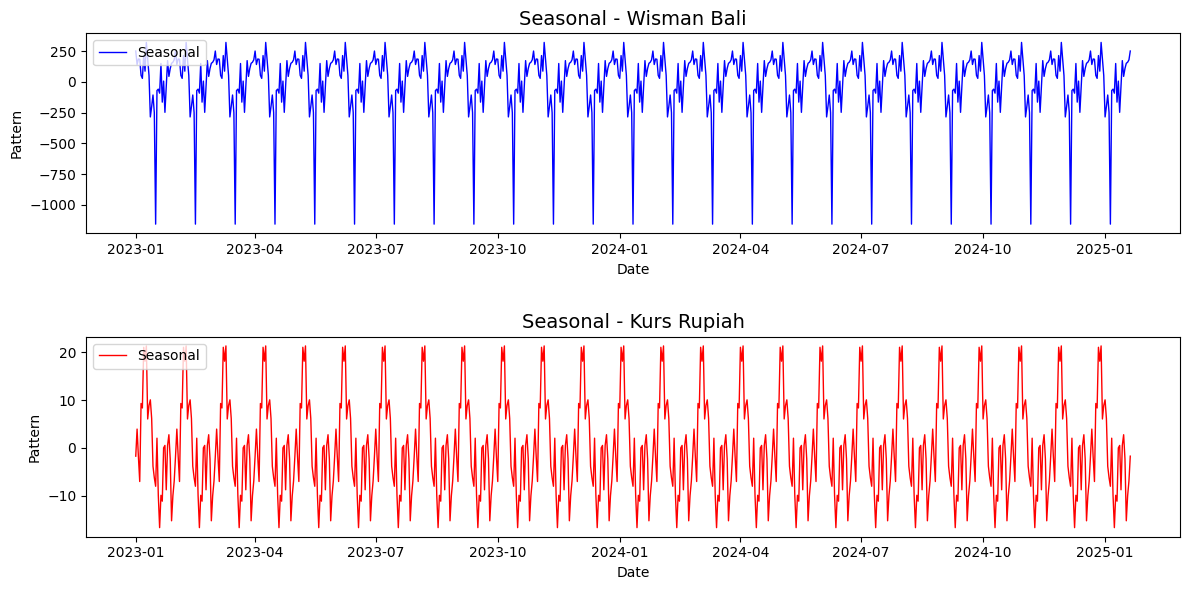

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose
stl_wisman = seasonal_decompose(df['Wisman Bali'], model='additive', period=30)
stl_kurs = seasonal_decompose(df['Kurs'], model='additive', period=30)
#Plotting only Trend components
plt.figure(figsize=(12, 6))
plt.plot(stl_wisman.trend, label='Trend Wisman Bali', color='blue', linewidth=1)
plt.plot(stl_kurs.trend, label='Trend Kurs', color='red', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Plot Trend Data Wisman Bali VS Kurs \n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()
# Plotting only Seasonal components
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(stl_wisman.seasonal, label='Seasonal', color='blue', linewidth=1)
plt.title('Seasonal - Wisman Bali', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Pattern')
plt.legend(loc='upper left')
plt.subplot(2, 1, 2)
plt.plot(stl_kurs.seasonal, label='Seasonal', color='red', linewidth=1)
plt.title('\nSeasonal - Kurs Rupiah', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Pattern')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

**Uji Korelasi**

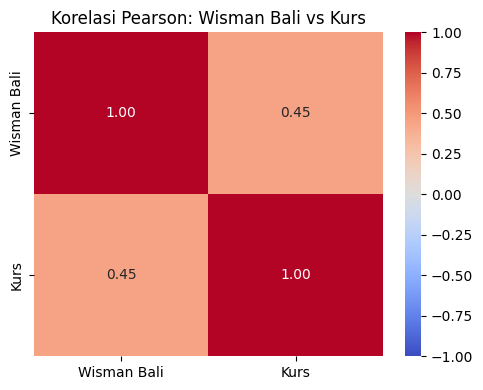

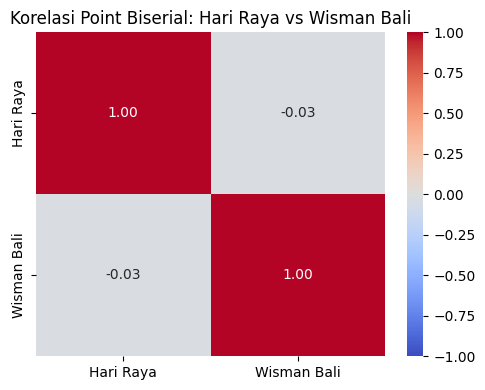

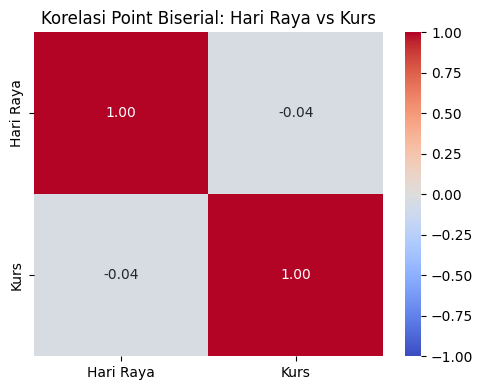

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, pointbiserialr

# Fungsi bantu untuk bikin heatmap 2x2
def plot_corr_heatmap(var1, var2, method, title):
    if method == 'pearson':
        corr_val, _ = pearsonr(df[var1], df[var2])
    elif method == 'biserial':
        corr_val, _ = pointbiserialr(df[var1], df[var2])

    corr_matrix = pd.DataFrame(
        [[1, corr_val], [corr_val, 1]],
        index=[var1, var2],
        columns=[var1, var2]
    )

    plt.figure(figsize=(5, 4))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# --- Panggil fungsi untuk masing-masing pasangan ---
plot_corr_heatmap('Wisman Bali', 'Kurs', 'pearson', 'Korelasi Pearson: Wisman Bali vs Kurs')
plot_corr_heatmap('Hari Raya', 'Wisman Bali', 'biserial', 'Korelasi Point Biserial: Hari Raya vs Wisman Bali')
plot_corr_heatmap('Hari Raya', 'Kurs', 'biserial', 'Korelasi Point Biserial: Hari Raya vs Kurs')


Hubungan Kurs & Wisman Bali cukup kuat (0.45), sehingga Kurs bisa menjadi variabel penting dalam model VARX.
Hari Raya tampaknya tidak terlalu berpengaruh signifikan terhadap Kurs atau Wisman Bali berdasarkan korelasi langsung.

**Uji T-test**

In [45]:
from scipy.stats import ttest_ind
# Pisahkan data saat Hari Raya dan bukan Hari Raya
kurs_hari_raya = df[df['Hari Raya'] == 1]['Kurs']
kurs_non_hari_raya = df[df['Hari Raya'] == 0]['Kurs']

t_stat, p_value = ttest_ind(kurs_hari_raya, kurs_non_hari_raya)
print(f"T-test Kurs: p-value = {p_value}")
wisman_hari_raya = df[df['Hari Raya'] == 1]['Wisman Bali']
wisman_non_hari_raya = df[df['Hari Raya'] == 0]['Wisman Bali']

t_stat, p_value = ttest_ind(wisman_hari_raya, wisman_non_hari_raya)
print(f"T-test Wisman: p-value = {p_value}")

T-test Kurs: p-value = 0.22660626813731768
T-test Wisman: p-value = 0.401275145836142


**Uji Kausalitas (Granger Causality)**

In [67]:
def granger_test(df, dep_var, indep_var, maxlag=9):
    print(f"\n Uji Granger Causality: Apakah {indep_var} memengaruhi {dep_var}?")
    result = grangercausalitytests(df[[dep_var, indep_var]], maxlag=maxlag, verbose=False)

    for lag in range(1, maxlag + 1):
        p_value = result[lag][0]['ssr_ftest'][1]  # Ambil p-value dari SSR F-test

        if p_value < 0.05:
            print(f"v Lag {lag}: p-value = {p_value:.4f} (< 0.05), {indep_var} **menyebabkan** {dep_var}.")
        else:
            print(f"x Lag {lag}: p-value = {p_value:.4f} (>= 0.05), tidak ada bukti signifikan bahwa {indep_var} menyebabkan {dep_var}.")

granger_test(df, 'Wisman Bali', 'Kurs', maxlag=9)
granger_test(df, 'Kurs', 'Wisman Bali', maxlag=9)


 Uji Granger Causality: Apakah Kurs memengaruhi Wisman Bali?
v Lag 1: p-value = 0.0000 (< 0.05), Kurs **menyebabkan** Wisman Bali.
v Lag 2: p-value = 0.0058 (< 0.05), Kurs **menyebabkan** Wisman Bali.
v Lag 3: p-value = 0.0401 (< 0.05), Kurs **menyebabkan** Wisman Bali.
x Lag 4: p-value = 0.0968 (>= 0.05), tidak ada bukti signifikan bahwa Kurs menyebabkan Wisman Bali.
x Lag 5: p-value = 0.2857 (>= 0.05), tidak ada bukti signifikan bahwa Kurs menyebabkan Wisman Bali.
x Lag 6: p-value = 0.3563 (>= 0.05), tidak ada bukti signifikan bahwa Kurs menyebabkan Wisman Bali.
x Lag 7: p-value = 0.6418 (>= 0.05), tidak ada bukti signifikan bahwa Kurs menyebabkan Wisman Bali.
x Lag 8: p-value = 0.1637 (>= 0.05), tidak ada bukti signifikan bahwa Kurs menyebabkan Wisman Bali.
x Lag 9: p-value = 0.1942 (>= 0.05), tidak ada bukti signifikan bahwa Kurs menyebabkan Wisman Bali.

 Uji Granger Causality: Apakah Wisman Bali memengaruhi Kurs?
x Lag 1: p-value = 0.4593 (>= 0.05), tidak ada bukti signifikan ba

In [47]:
from statsmodels.tsa.stattools import coint
coint_result = coint(df['Kurs'], df['Wisman Bali'])
print("Engle-Granger Cointegration Test")
print(f"Test Statistic: {coint_result[0]}")
print(f"p-value: {coint_result[1]}")
if coint_result[1] < 0.05:
    print("Seri ini berkointegrasi (p < 0.05).")
else:
    print("Seri ini tidak berkointegrasi.")

Engle-Granger Cointegration Test
Test Statistic: -1.6729832849805746
p-value: 0.6891270418731206
Seri ini tidak berkointegrasi.


Augmented Dickey-Fuller Test

Wisman Bali
   Test Statistic: -1.9459
   p-value: 0.3108
   Critical Values: {'1%': np.float64(-3.4393396487377155), '5%': np.float64(-2.865507363200066), '10%': np.float64(-2.5688826684180897)}
   Tidak Stasioner

Kurs
   Test Statistic: -1.2767
   p-value: 0.6398
   Critical Values: {'1%': np.float64(-3.4392057325732104), '5%': np.float64(-2.8654483492874236), '10%': np.float64(-2.5688512291811225)}
   Tidak Stasioner


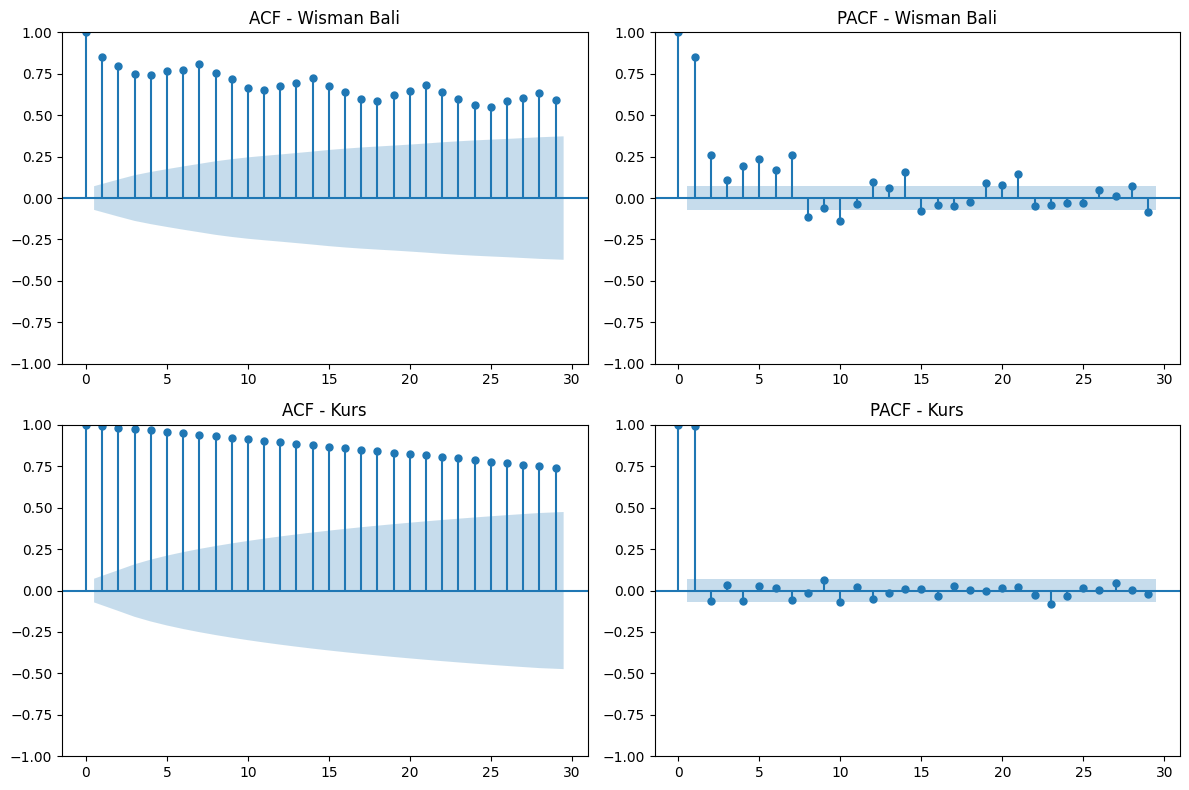

In [48]:
def adf_test(series, signif=0.05):
    stat, p_value, _, _, critical_values, _ = adfuller(series, autolag='AIC')
    return p_value <= signif, {'Test Statistic': stat, 'p-value': p_value, 'Critical Values': critical_values}

stationary_wisman, adf_wisman = adf_test(df_norm['Wisman Bali'])
stationary_kurs, adf_kurs = adf_test(df_norm['Kurs'])
print("Augmented Dickey-Fuller Test")
for name, result, stationary in zip(["Wisman Bali", "Kurs"], [adf_wisman, adf_kurs], [stationary_wisman, stationary_kurs]):
    print(f"\n{name}")
    print(f"   Test Statistic: {result['Test Statistic']:.4f}")
    print(f"   p-value: {result['p-value']:.4f}")
    print(f"   Critical Values: {result['Critical Values']}")
    print(f"   {'Stasioner' if stationary else 'Tidak Stasioner'}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(df_norm['Wisman Bali'], ax=axes[0, 0], title="ACF - Wisman Bali")
plot_pacf(df_norm['Wisman Bali'], ax=axes[0, 1], title="PACF - Wisman Bali")
plot_acf(df_norm['Kurs'], ax=axes[1, 0], title="ACF - Kurs")
plot_pacf(df_norm['Kurs'], ax=axes[1, 1], title="PACF - Kurs")

plt.tight_layout()
plt.show()


ADF Test Setelah Differencing

Wisman Bali (Setelah Differencing)
   Test Statistic: -9.1489
   p-value: 0.0000
   Critical Values: {'1%': np.float64(-3.4393396487377155), '5%': np.float64(-2.865507363200066), '10%': np.float64(-2.5688826684180897)}
   Stasioner

Kurs (Setelah Differencing)
   Test Statistic: -8.1313
   p-value: 0.0000
   Critical Values: {'1%': np.float64(-3.4392057325732104), '5%': np.float64(-2.8654483492874236), '10%': np.float64(-2.5688512291811225)}
   Stasioner


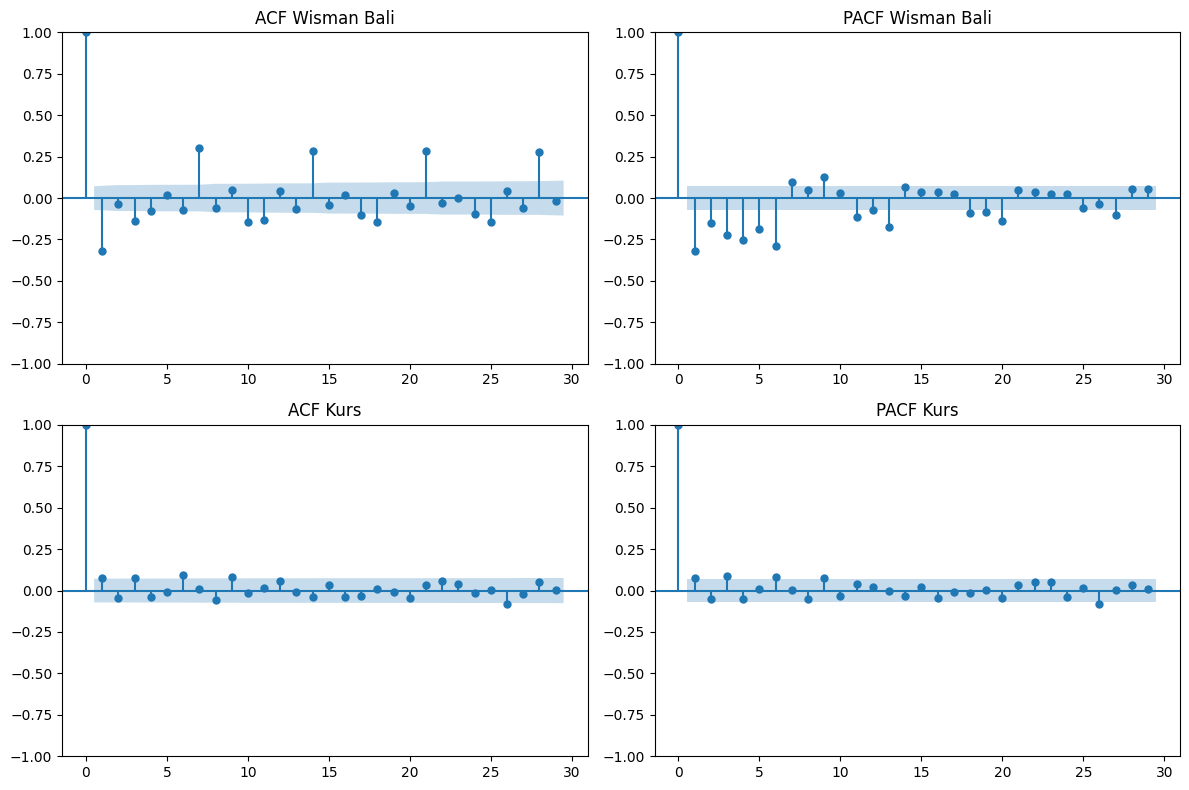

In [49]:
endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Raya']

df_norm_diff = df_norm.copy()
df_norm_diff[endog_vars] = df_norm[endog_vars].diff().dropna() # Differencing hanya untuk variabel endogen
df_norm_diff[exog_vars] = df_norm[exog_vars] # Eksogen tetap pakai data aslinya
df_norm_diff = df_norm_diff.dropna()

stationary_wisman_diff, adf_wisman_diff = adf_test(df_norm_diff['Wisman Bali'])
stationary_kurs_diff, adf_kurs_diff = adf_test(df_norm_diff['Kurs'])
print("ADF Test Setelah Differencing")
for name, result, stationary in zip(["Wisman Bali", "Kurs"], [adf_wisman_diff, adf_kurs_diff], [stationary_wisman_diff, stationary_kurs_diff]):
    print(f"\n{name} (Setelah Differencing)")
    print(f"   Test Statistic: {result['Test Statistic']:.4f}")
    print(f"   p-value: {result['p-value']:.4f}")
    print(f"   Critical Values: {result['Critical Values']}")
    print(f"   {'Stasioner' if stationary else 'Tidak Stasioner'}")


fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(df_norm_diff['Wisman Bali'], ax=axes[0, 0], title="ACF Wisman Bali")
plot_pacf(df_norm_diff['Wisman Bali'], ax=axes[0, 1], title="PACF Wisman Bali")
plot_acf(df_norm_diff['Kurs'], ax=axes[1, 0], title="ACF Kurs")
plot_pacf(df_norm_diff['Kurs'], ax=axes[1, 1], title="PACF Kurs")

plt.tight_layout()
plt.show()


## **Modeling**

### **VARX**

#####**Time Based Splitting**

Jumlah data latih: 711
Jumlah data uji: 40


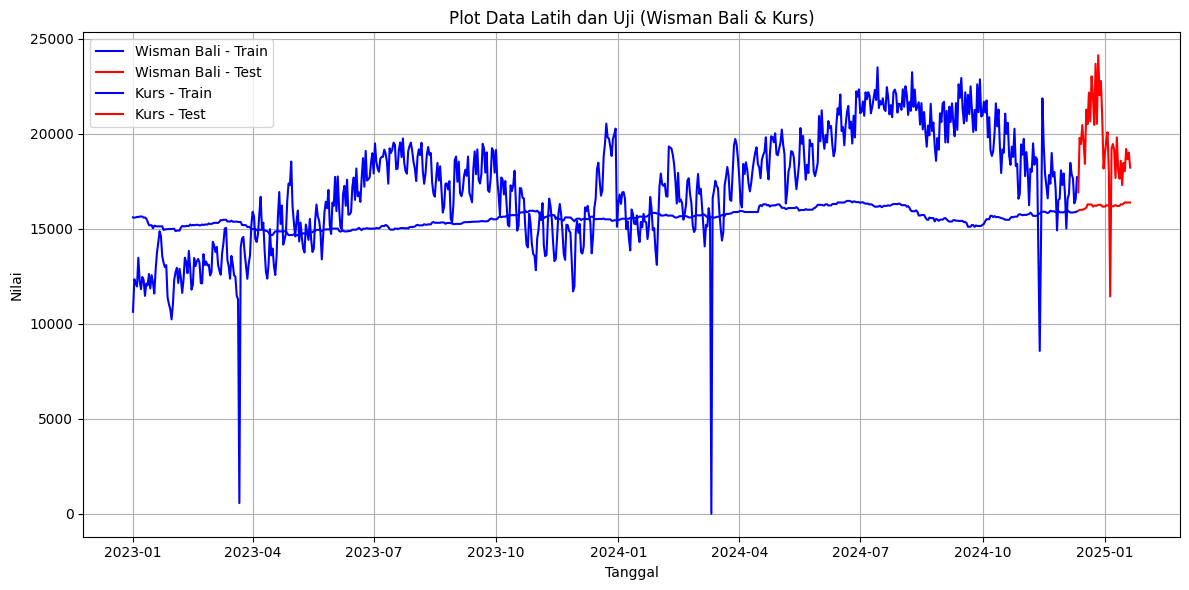

In [50]:
test_size = 40
train_data = df.iloc[:-test_size]
test_data = df.iloc[-test_size:]

print("Jumlah data latih:", len(train_data))
print("Jumlah data uji:", len(test_data))

# Plot Wisman Bali dan Kurs
plt.figure(figsize=(12, 6))

# Wisman Bali
plt.plot(train_data.index, train_data['Wisman Bali'], label='Wisman Bali - Train', color='blue')
plt.plot(test_data.index, test_data['Wisman Bali'], label='Wisman Bali - Test', color='red')

# Kurs
plt.plot(train_data.index, train_data['Kurs'], label='Kurs - Train', color='blue')
plt.plot(test_data.index, test_data['Kurs'], label='Kurs - Test', color='red')

plt.title('Plot Data Latih dan Uji (Wisman Bali & Kurs)')
plt.xlabel('Tanggal')
plt.ylabel('Nilai')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Jumlah data latih: 710
Jumlah data uji: 40


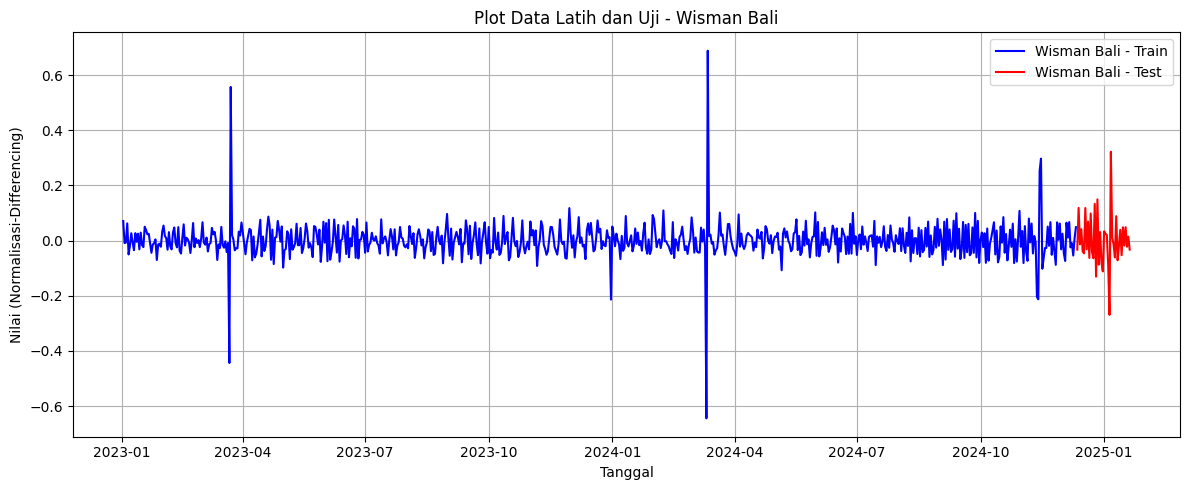

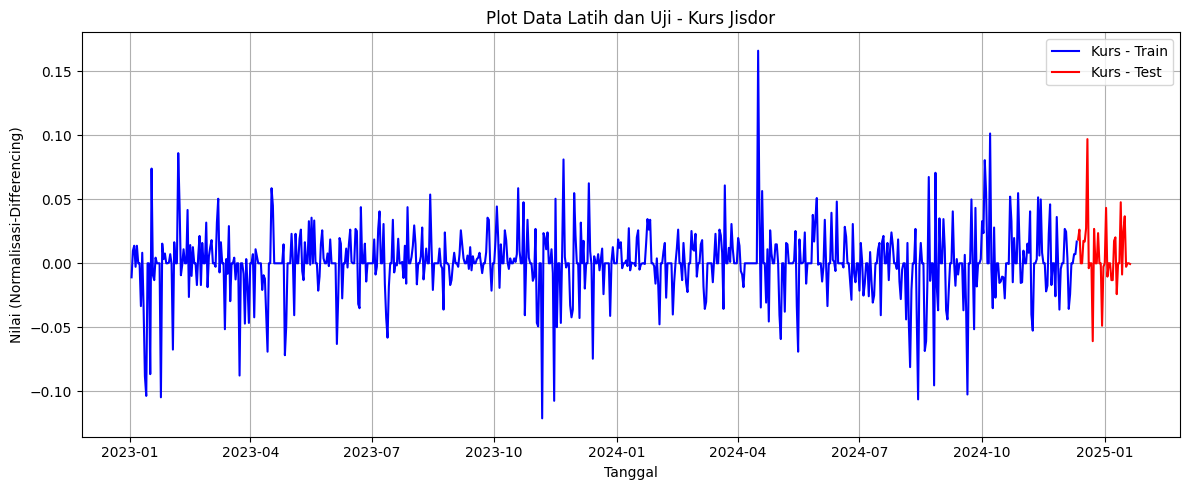

In [51]:
test_size = 40
train_data = df_norm_diff.iloc[:-test_size]
test_data = df_norm_diff.iloc[-test_size:]

print("Jumlah data latih:", len(train_data))
print("Jumlah data uji:", len(test_data))

# Plot Wisman Bali
plt.figure(figsize=(12, 5))
plt.plot(train_data.index, train_data['Wisman Bali'], label='Wisman Bali - Train', color='blue')
plt.plot(test_data.index, test_data['Wisman Bali'], label='Wisman Bali - Test', color='red')
plt.title('Plot Data Latih dan Uji - Wisman Bali')
plt.xlabel('Tanggal')
plt.ylabel('Nilai (Normalisasi-Differencing)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Kurs
plt.figure(figsize=(12, 5))
plt.plot(train_data.index, train_data['Kurs'], label='Kurs - Train', color='blue')
plt.plot(test_data.index, test_data['Kurs'], label='Kurs - Test', color='red')
plt.title('Plot Data Latih dan Uji - Kurs Jisdor')
plt.xlabel('Tanggal')
plt.ylabel('Nilai (Normalisasi-Differencing)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
from statsmodels.tsa.statespace.varmax import VARMAX

endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Raya']

# Split data
test_size = 40
train = df_norm_diff.iloc[:-test_size]
test = df_norm_diff.iloc[-test_size:]

# Cari lag optimal (1 sampai 15)
lag_selection = []
for lag in range(1, 16):
    try:
        model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(lag, 0))
        results = model.fit(disp=False)
        lag_selection.append({
            'Lag': lag,
            'AIC': results.aic,
            'BIC': results.bic
        })
    except Exception as e:
        print(f"Error pada lag {lag}: {e}")
        continue

df_lag = pd.DataFrame(lag_selection)
print("\nEvaluasi Lag:\n", df_lag)

if df_lag.empty:
    print("Tidak ada model yang berhasil difit.")
else:
    # Pilih lag terbaik (berdasarkan AIC terkecil)
    best_idx = df_lag['AIC'].idxmin()
    best_order = int(df_lag.loc[best_idx, 'Lag'])

    # Fit model akhir
    best_model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(best_order, 0)).fit(disp=False)
    print(f"\nBest Lag: {best_order} | AIC: {best_model.aic:.2f}")
    print(best_model.summary())


Evaluasi Lag:
     Lag          AIC          BIC
0     1 -5091.353874 -5041.135959
1     2 -5101.882370 -5033.403396
2     3 -5140.856663 -5054.116628
3     4 -5189.141016 -5084.139922
4     5 -5218.203851 -5094.941696
5     6 -5290.313202 -5148.789988
6     7 -5293.126962 -5133.342688
7     8 -5289.812501 -5111.767168
8     9 -5302.556945 -5106.250551
9    10 -5296.722711 -5082.155257
10   11 -5301.171327 -5068.342813
11   12 -5299.296037 -5048.206464
12   13 -5312.375932 -5043.025298
13   14 -5316.870241 -5029.258548
14   15 -5311.046384 -5005.173631

Best Lag: 14 | AIC: -5316.87
                              Statespace Model Results                             
Dep. Variable:     ['Kurs', 'Wisman Bali']   No. Observations:                  710
Model:                            VARX(14)   Log Likelihood                2721.435
                               + intercept   AIC                          -5316.870
Date:                     Fri, 11 Apr 2025   BIC                          

In [53]:
from statsmodels.tsa.statespace.varmax import VARMAX

endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Raya']

# Split data
test_size = 40
train = df_norm_diff.iloc[:-test_size]
test = df_norm_diff.iloc[-test_size:]

# Cari lag optimal (1 sampai 15)
lag_selection = []
for lag in range(1, 16):
    try:
        model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(lag, 0))
        results = model.fit(disp=False)
        lag_selection.append({
            'Lag': lag,
            'AIC': results.aic,
            'BIC': results.bic
        })
    except Exception as e:
        print(f"Error pada lag {lag}: {e}")
        continue

df_lag = pd.DataFrame(lag_selection)
print("\nEvaluasi Lag:\n", df_lag)

if df_lag.empty:
    print("Tidak ada model yang berhasil difit.")
else:
    # Pilih lag terbaik (berdasarkan AIC terkecil)
    best_idx = df_lag['BIC'].idxmin()
    best_order = int(df_lag.loc[best_idx, 'Lag'])

    # Fit model akhir
    best_model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(best_order, 0)).fit(disp=False)
    print(f"\nBest Lag: {best_order} | BIC: {best_model.aic:.2f}")
    print(best_model.summary())


Evaluasi Lag:
     Lag          AIC          BIC
0     1 -5091.353874 -5041.135959
1     2 -5101.882370 -5033.403396
2     3 -5140.856663 -5054.116628
3     4 -5189.141016 -5084.139922
4     5 -5218.203851 -5094.941696
5     6 -5290.313202 -5148.789988
6     7 -5293.126962 -5133.342688
7     8 -5289.812501 -5111.767168
8     9 -5302.556945 -5106.250551
9    10 -5296.722711 -5082.155257
10   11 -5301.171327 -5068.342813
11   12 -5299.296037 -5048.206464
12   13 -5312.375932 -5043.025298
13   14 -5316.870241 -5029.258548
14   15 -5311.046384 -5005.173631

Best Lag: 6 | BIC: -5290.31
                              Statespace Model Results                             
Dep. Variable:     ['Kurs', 'Wisman Bali']   No. Observations:                  710
Model:                             VARX(6)   Log Likelihood                2676.157
                               + intercept   AIC                          -5290.313
Date:                     Fri, 11 Apr 2025   BIC                          -

In [54]:
endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Raya']
test_size = 40

# Split data
train = df_norm_diff.iloc[:-test_size]
test = df_norm_diff.iloc[-test_size:]

# Dictionary untuk simpan hasil forecast dan MAPE
results_by_lag = {}

for lag in [6, 14]:
    try:
        print(f"\n=== LAG {lag} ===")
        model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(lag, 0))
        fitted_model = model.fit(disp=False)
        print(f"AIC: {fitted_model.aic:.2f} | BIC: {fitted_model.bic:.2f}")

        # Forecast
        forecast_norm = fitted_model.forecast(steps=test_size, exog=test[exog_vars])

        # Denormalisasi
        forecast_denorm = pd.DataFrame(scaler.inverse_transform(forecast_norm),
                                       columns=endog_vars, index=test.index)
        test_denorm = pd.DataFrame(scaler.inverse_transform(test[endog_vars]),
                                   columns=endog_vars, index=test.index)

        # Reverse differencing
        last_actual = df[endog_vars].iloc[-test_size - 1]

        forecast_reversed = forecast_denorm.cumsum() + last_actual
        test_reversed = test_denorm.cumsum() + last_actual

        # MAPE
        mape_kurs = mean_absolute_percentage_error(test_reversed['Kurs'], forecast_reversed['Kurs'])
        mape_wisman = mean_absolute_percentage_error(test_reversed['Wisman Bali'], forecast_reversed['Wisman Bali'])

        print(f"MAPE Kurs: {mape_kurs:.4f}")
        print(f"MAPE Wisman Bali: {mape_wisman:.4f}")

        # Simpan ke dictionary
        results_by_lag[lag] = {
            'model': fitted_model,
            'forecast': forecast_reversed,
            'mape_kurs': mape_kurs,
            'mape_wisman': mape_wisman
        }

    except Exception as e:
        print(f"Error di lag {lag}: {e}")



=== LAG 6 ===
AIC: -5290.31 | BIC: -5148.79
MAPE Kurs: 0.0011
MAPE Wisman Bali: 0.1186

=== LAG 14 ===
AIC: -5316.87 | BIC: -5029.26
MAPE Kurs: 0.0011
MAPE Wisman Bali: 0.1147


####**Sliding Cross Validation Lag Optimal**

#####**3 Bulan**

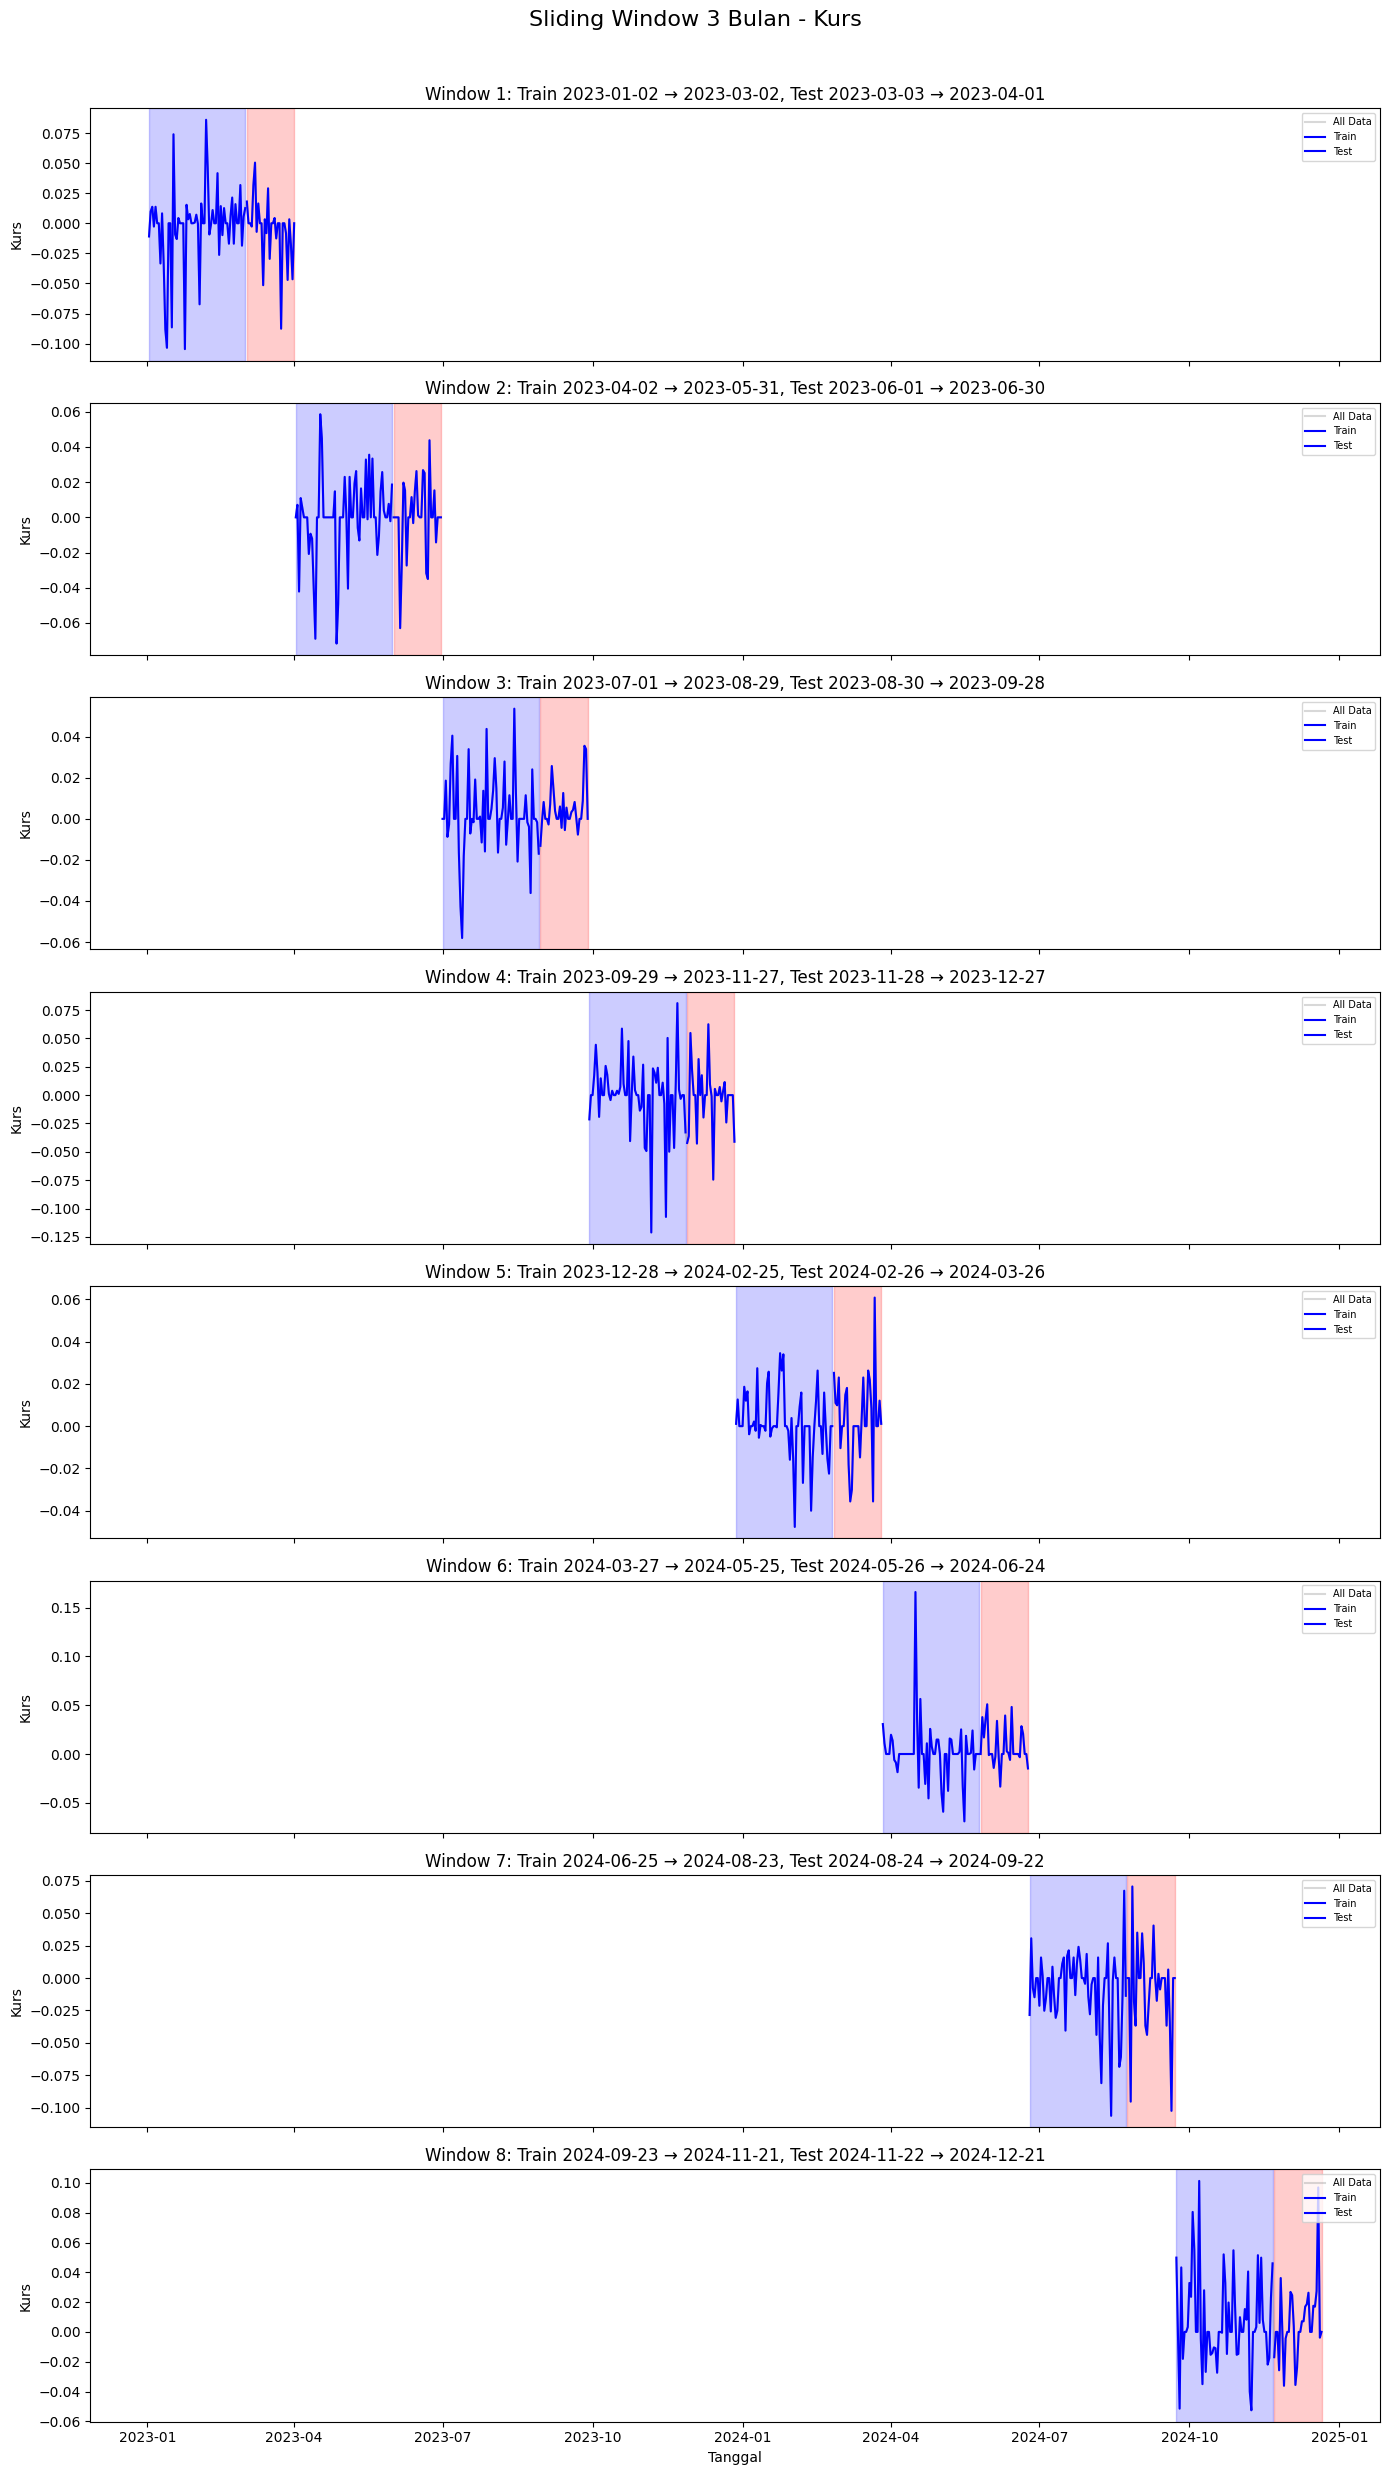

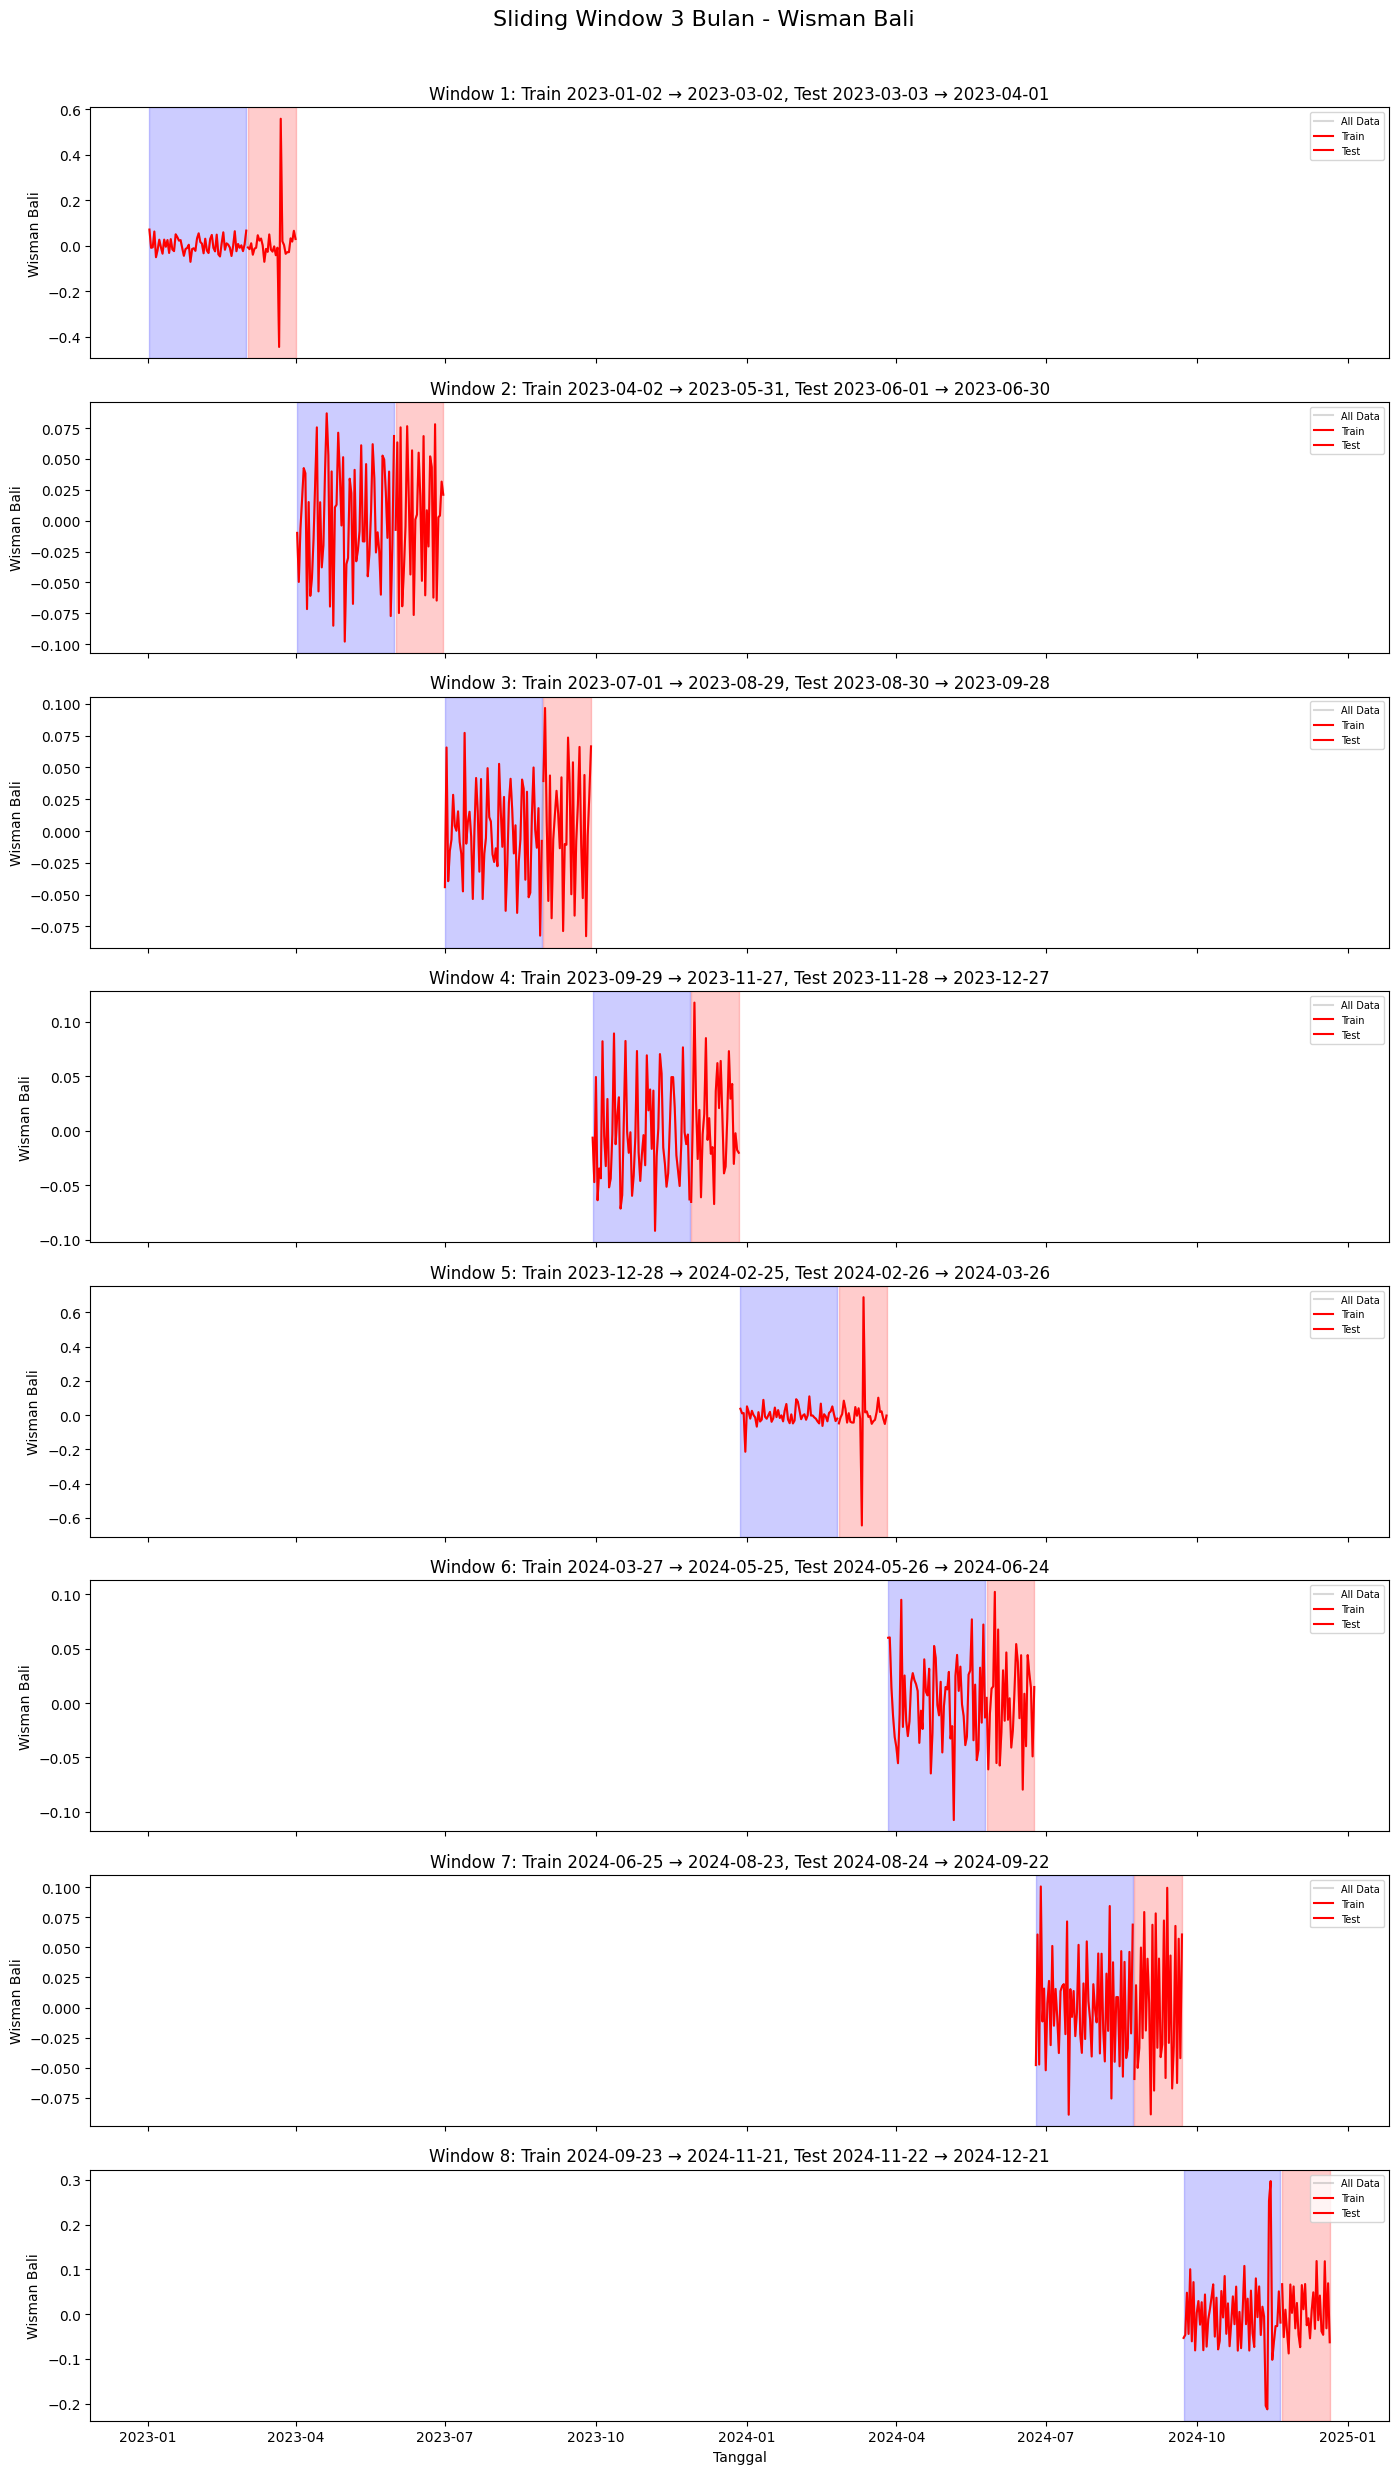

In [55]:
# Parameter sliding window
window_size = 90
n_test = 30
n_train = window_size - n_test
shift = 90
n_windows = 8
n_total = len(df_norm_diff)

def plot_windows(df, var, color, label):
    fig, axes = plt.subplots(n_windows, 1, figsize=(14, 26), sharex=True)

    for i in range(n_windows):
        start, end = i * shift, i * shift + window_size
        if end > n_total:
            print(f"Window {i+1} out of bounds.")
            break

        window_data = df.iloc[start:end]
        train = window_data.iloc[:n_train]
        test = window_data.iloc[n_train:]
        ax = axes[i]

        ax.plot(window_data.index, window_data[var], color='gray', alpha=0.3, label='All Data')
        ax.axvspan(train.index[0], train.index[-1], color='blue', alpha=0.2)
        ax.axvspan(test.index[0], test.index[-1], color='red', alpha=0.2)
        ax.plot(train.index, train[var], color=color, label='Train')
        ax.plot(test.index, test[var], color=color, label='Test')

        ax.set_title(f"Window {i+1}: Train {train.index[0].date()} → {train.index[-1].date()}, Test {test.index[0].date()} → {test.index[-1].date()}")
        ax.set_ylabel(label)
        ax.legend(loc='upper right', fontsize=7)

    plt.xlabel("Tanggal")
    plt.suptitle(f"Sliding Window 3 Bulan - {label}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# Plot masing-masing variabel
plot_windows(df_norm_diff, 'Kurs', 'blue', 'Kurs')
plot_windows(df_norm_diff, 'Wisman Bali', 'red', 'Wisman Bali')


In [56]:
from statsmodels.tsa.statespace.varmax import VARMAX

endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Raya']

# Sliding window 3 bulan
window_size = 90
n_test = 30
n_train = window_size - n_test
shift = 90
n_windows = 8
n_total = len(df_norm_diff)

for i in range(n_windows):
    start = i * shift
    end = start + window_size
    if end > n_total:
        print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
        break

    window_data = df_norm_diff.iloc[start:end]
    train = window_data.iloc[:n_train]
    test = window_data.iloc[n_train:]

    # Cari lag optimal (1 sampai 15)
    lag_selection = []
    for lag in range(1, 16):
        try:
            model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(lag, 0))
            results = model.fit(disp=False)
            lag_selection.append({
                'Lag': lag,
                'AIC': results.aic,
                'BIC': results.bic
            })
        except Exception as e:
            print(f"Error pada lag {lag} di Window {i+1}: {e}")
            continue

    df_lag = pd.DataFrame(lag_selection)
    print(f"\nWindow {i+1} - Evaluasi Lag:\n{df_lag}")

    if df_lag.empty:
        print(f"Window {i+1}: Tidak ada model yang berhasil difit.")
        continue

    # Pilih lag terbaik (berdasarkan AIC terkecil)
    best_idx = df_lag['AIC'].idxmin()
    best_order = int(df_lag.loc[best_idx, 'Lag'])

    # Fit model akhir
    best_model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(best_order, 0)).fit(disp=False)
    print(f"\nWindow {i+1} | Best Lag: {best_order} | AIC: {best_model.aic:.2f}")
    print(best_model.summary())



Window 1 - Evaluasi Lag:
    Lag         AIC         BIC
0     1 -460.753462 -437.715671
1     2 -456.979142 -425.563973
2     3 -456.235817 -416.443271
3     4 -448.984301 -400.814376
4     5 -451.725178 -395.177875
5     6 -451.024260 -386.099579
6     7 -452.383819 -379.081759
7     8 -447.031011 -365.351573
8     9 -458.296034 -368.239217
9    10 -460.816217 -362.382023
10   11 -475.674975 -368.863402
11   12 -475.934289 -360.745338
12   13 -477.195371 -353.629041
13   14 -460.489772 -328.546064
14   15 -458.119231 -317.798145

Window 1 | Best Lag: 13 | AIC: -477.20
                              Statespace Model Results                             
Dep. Variable:     ['Kurs', 'Wisman Bali']   No. Observations:                   60
Model:                            VARX(13)   Log Likelihood                 297.598
                               + intercept   AIC                           -477.195
Date:                     Fri, 11 Apr 2025   BIC                           -353.629
Ti

Lag 6

In [57]:
endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Raya']

# Parameter sliding window 3 bulan
window_size = 90        # 3 bulan data
n_test = 30             # 1 bulan test
n_train = window_size - n_test  # 2 bulan train
shift = 90              # geser per 3 bulan
n_windows1 = 8
n_total = len(df_norm)

mape_kurs_scores = []
mape_wisman_scores = []

for i in range(n_windows1):
    start = i * shift
    end = start + window_size
    if end > n_total:
        print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
        break

    window_data = df_norm.iloc[start:end]
    train = window_data.iloc[:n_train]
    test = window_data.iloc[n_train:]

    try:
        model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(6, 0))
        best_model = model.fit(disp=False)
        print(f"\nWindow {i+1} | Lag: 6 | AIC: {best_model.aic:.2f}")
        print(best_model.summary())

        # Forecast (masih dalam bentuk normalisasi)
        forecast_norm = best_model.forecast(steps=n_test, exog=test[exog_vars])

        # Denormalisasi forecast dan test data
        forecast_denorm = pd.DataFrame(scaler.inverse_transform(forecast_norm),
                                       columns=endog_vars, index=test.index)
        test_denorm = pd.DataFrame(scaler.inverse_transform(test[endog_vars]),
                                   columns=endog_vars, index=test.index)

        # Ambil nilai terakhir dari training data asli (bukan differenced)
        last_actual = df[endog_vars].iloc[start + n_train - 1]

        # Reverse differencing forecast
        forecast_reversed = forecast_denorm.copy()
        for col in endog_vars:
            forecast_reversed[col] = forecast_denorm[col].cumsum() + last_actual[col]

        # Reverse juga untuk test
        test_reversed = test_denorm.copy()
        for col in endog_vars:
            base = df[endog_vars][col].iloc[start + n_train - 1]
            test_reversed[col] = test_denorm[col].cumsum() + base

        # Hitung MAPE setelah reverse differencing
        mape_kurs = mean_absolute_percentage_error(test_reversed['Kurs'], forecast_reversed['Kurs'])
        mape_wisman = mean_absolute_percentage_error(test_reversed['Wisman Bali'], forecast_reversed['Wisman Bali'])

        mape_kurs_scores.append(mape_kurs)
        mape_wisman_scores.append(mape_wisman)

        print(f"Window {i+1} MAPE Kurs: {mape_kurs:.4f}, MAPE Wisman: {mape_wisman:.4f}")

    except Exception as e:
        print(f"Error pada Window {i+1}: {e}")
        continue

# Rata-rata MAPE akhir
if mape_kurs_scores and mape_wisman_scores:
    final_mape_kurs = np.mean(mape_kurs_scores)
    final_mape_wisman = np.mean(mape_wisman_scores)
    print(f"\nFinal Average MAPE Kurs: {final_mape_kurs:.4f}")
    print(f"Final Average MAPE Wisman: {final_mape_wisman:.4f}")


Window 1 | Lag: 6 | AIC: -429.17
                              Statespace Model Results                             
Dep. Variable:     ['Kurs', 'Wisman Bali']   No. Observations:                   60
Model:                             VARX(6)   Log Likelihood                 245.586
                               + intercept   AIC                           -429.173
Date:                     Fri, 11 Apr 2025   BIC                           -364.248
Time:                             13:59:33   HQIC                          -403.777
Sample:                         01-01-2023                                         
                              - 03-01-2023                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             3.43, 0.00   Jarque-Bera (JB):          25.79, 0.17
Prob(Q):                        0.06, 0.95   Prob(JB):                   0.00, 0.92
Heteroskedasticity (H):         0.16, 0.62

Lag 7

In [58]:
endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Raya']

# Parameter sliding window 3 bulan
window_size = 90        # 3 bulan data
n_test = 30             # 1 bulan test
n_train = window_size - n_test  # 2 bulan train
shift = 90              # geser per 3 bulan
n_windows1 = 8
n_total = len(df_norm)

mape_kurs_scores = []
mape_wisman_scores = []

for i in range(n_windows1):
    start = i * shift
    end = start + window_size
    if end > n_total:
        print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
        break

    window_data = df_norm.iloc[start:end]
    train = window_data.iloc[:n_train]
    test = window_data.iloc[n_train:]

    try:
        model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(7, 0))
        best_model = model.fit(disp=False)
        print(f"\nWindow {i+1} | Lag: 7 | AIC: {best_model.aic:.2f}")
        print(best_model.summary())

        # Forecast (masih dalam bentuk normalisasi)
        forecast_norm = best_model.forecast(steps=n_test, exog=test[exog_vars])

        # Denormalisasi forecast dan test data
        forecast_denorm = pd.DataFrame(scaler.inverse_transform(forecast_norm),
                                       columns=endog_vars, index=test.index)
        test_denorm = pd.DataFrame(scaler.inverse_transform(test[endog_vars]),
                                   columns=endog_vars, index=test.index)

        # Ambil nilai terakhir dari training data asli (bukan differenced)
        last_actual = df[endog_vars].iloc[start + n_train - 1]

        # Reverse differencing forecast
        forecast_reversed = forecast_denorm.copy()
        for col in endog_vars:
            forecast_reversed[col] = forecast_denorm[col].cumsum() + last_actual[col]

        # Reverse juga untuk test
        test_reversed = test_denorm.copy()
        for col in endog_vars:
            base = df[endog_vars][col].iloc[start + n_train - 1]
            test_reversed[col] = test_denorm[col].cumsum() + base

        # Hitung MAPE setelah reverse differencing
        mape_kurs = mean_absolute_percentage_error(test_reversed['Kurs'], forecast_reversed['Kurs'])
        mape_wisman = mean_absolute_percentage_error(test_reversed['Wisman Bali'], forecast_reversed['Wisman Bali'])

        mape_kurs_scores.append(mape_kurs)
        mape_wisman_scores.append(mape_wisman)

        print(f"Window {i+1} MAPE Kurs: {mape_kurs:.4f}, MAPE Wisman: {mape_wisman:.4f}")

    except Exception as e:
        print(f"Error pada Window {i+1}: {e}")
        continue

# Rata-rata MAPE akhir
if mape_kurs_scores and mape_wisman_scores:
    final_mape_kurs = np.mean(mape_kurs_scores)
    final_mape_wisman = np.mean(mape_wisman_scores)
    print(f"\nFinal Average MAPE Kurs: {final_mape_kurs:.4f}")
    print(f"Final Average MAPE Wisman: {final_mape_wisman:.4f}")


Window 1 | Lag: 7 | AIC: -429.89
                              Statespace Model Results                             
Dep. Variable:     ['Kurs', 'Wisman Bali']   No. Observations:                   60
Model:                             VARX(7)   Log Likelihood                 249.946
                               + intercept   AIC                           -429.892
Date:                     Fri, 11 Apr 2025   BIC                           -356.589
Time:                             14:00:17   HQIC                          -401.219
Sample:                         01-01-2023                                         
                              - 03-01-2023                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.11, 0.01   Jarque-Bera (JB):          24.41, 0.28
Prob(Q):                        0.74, 0.93   Prob(JB):                   0.00, 0.87
Heteroskedasticity (H):         0.33, 0.61

#####**4 Bulan**

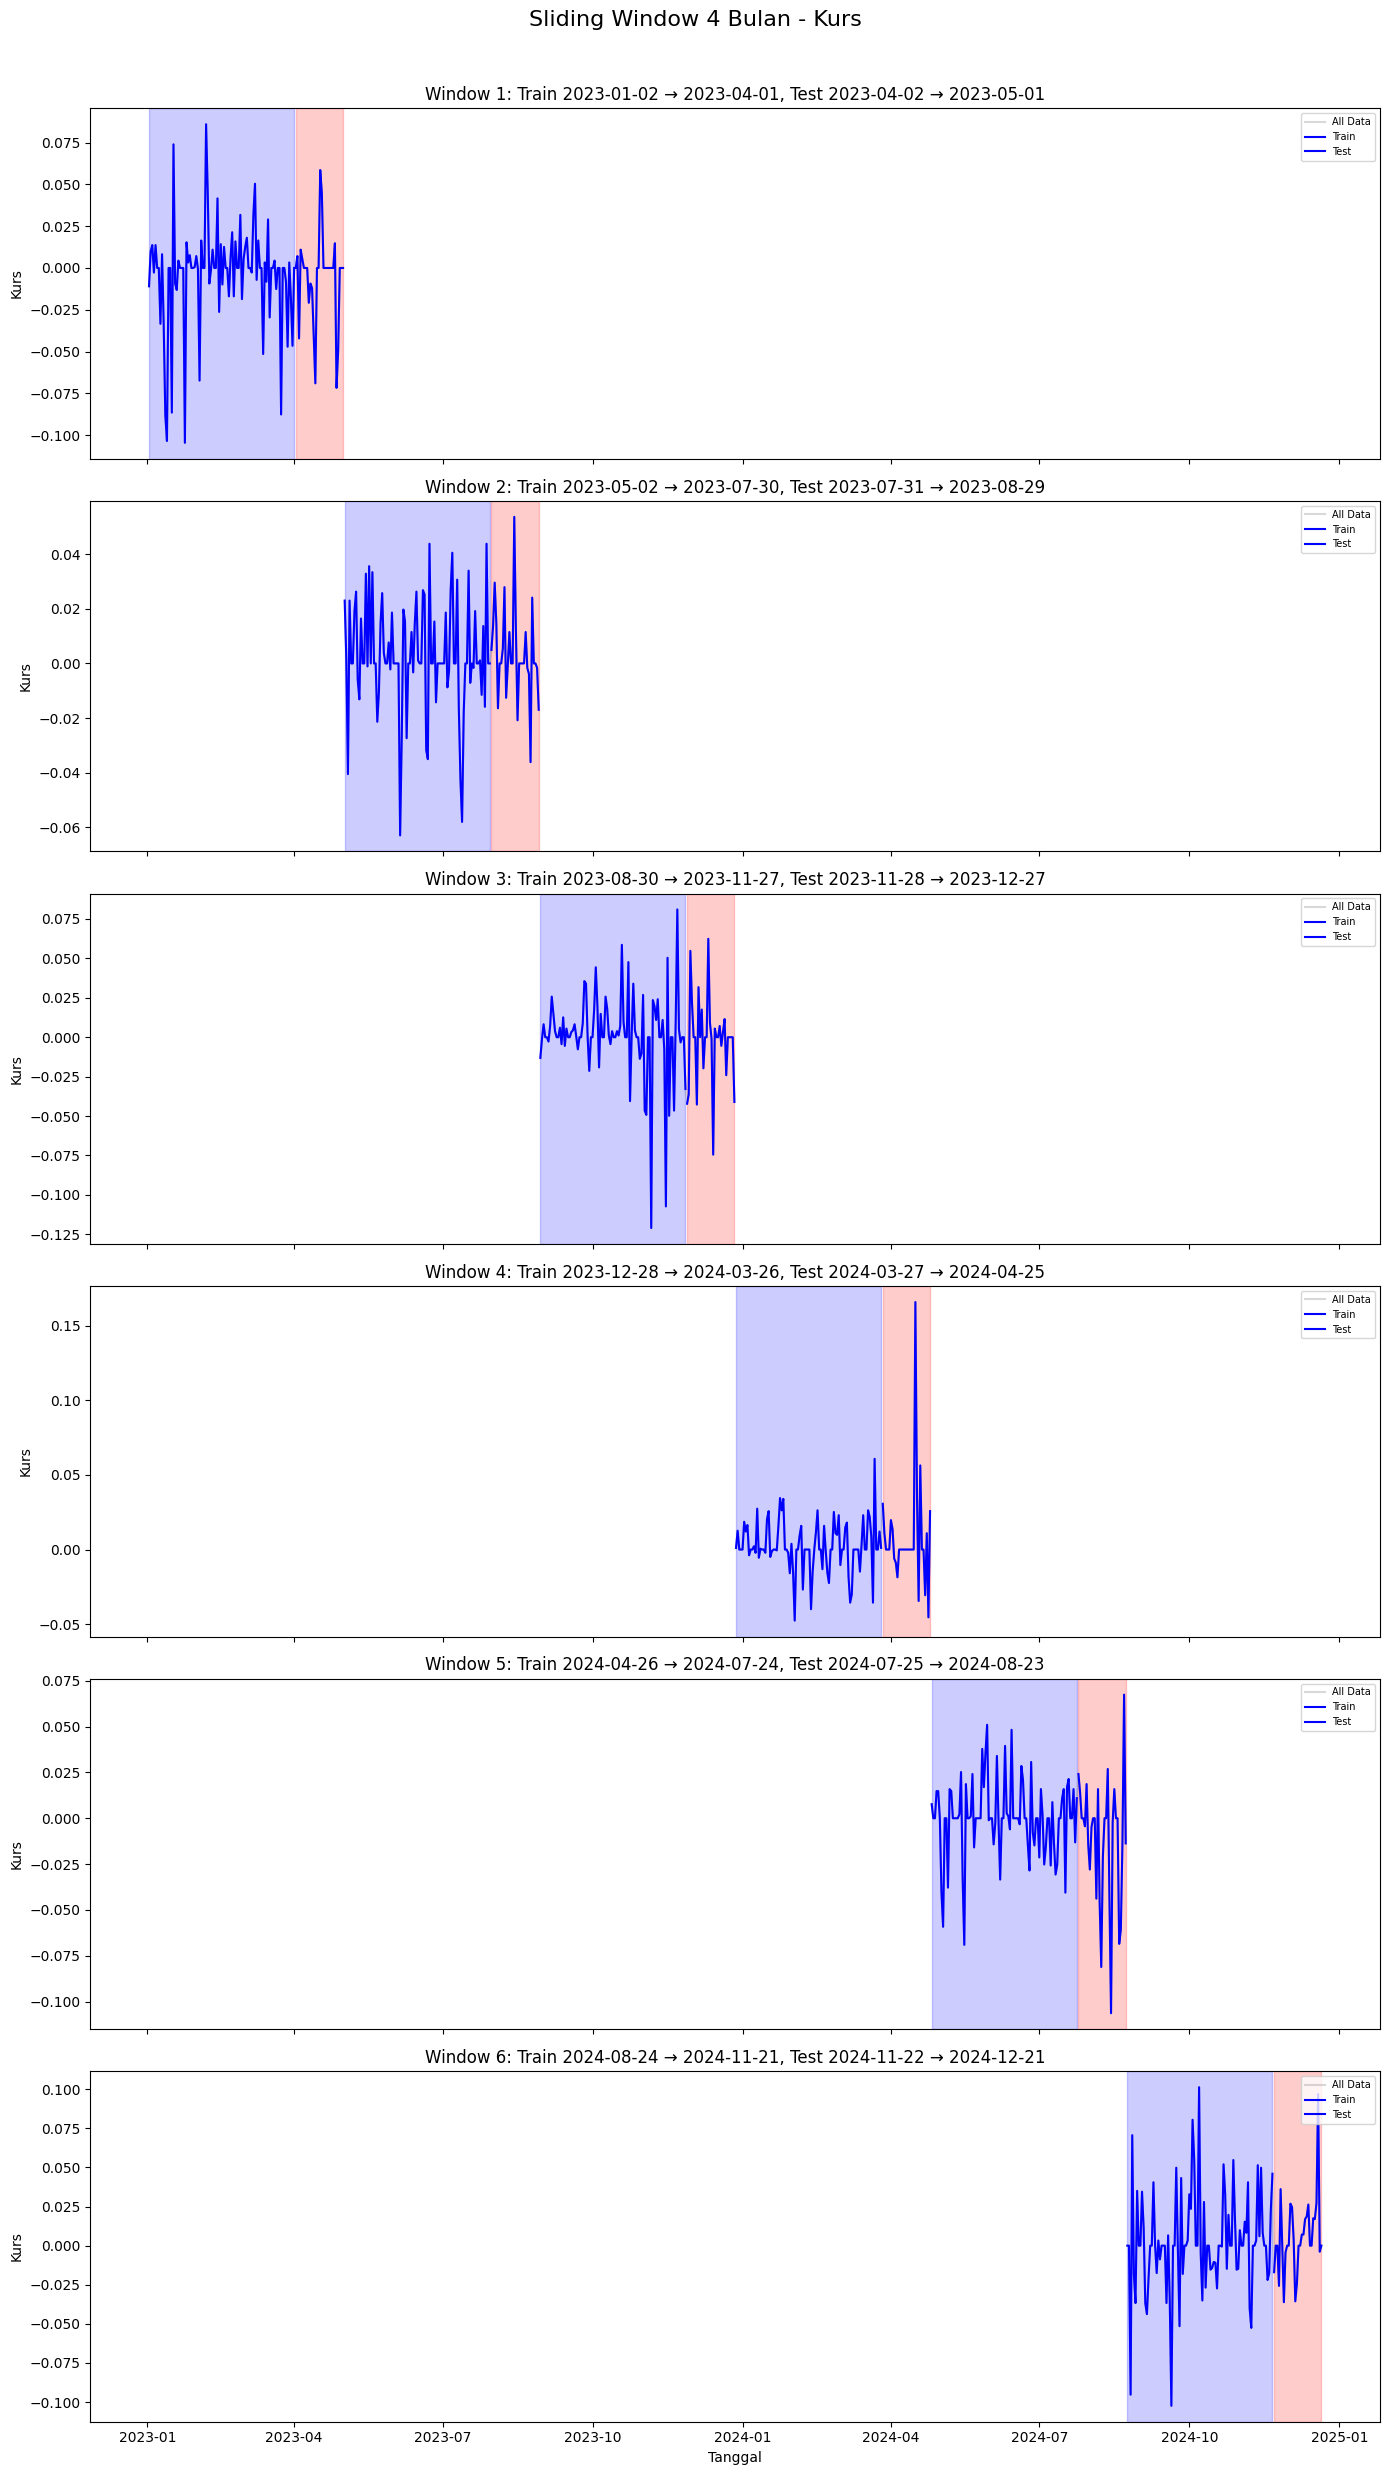

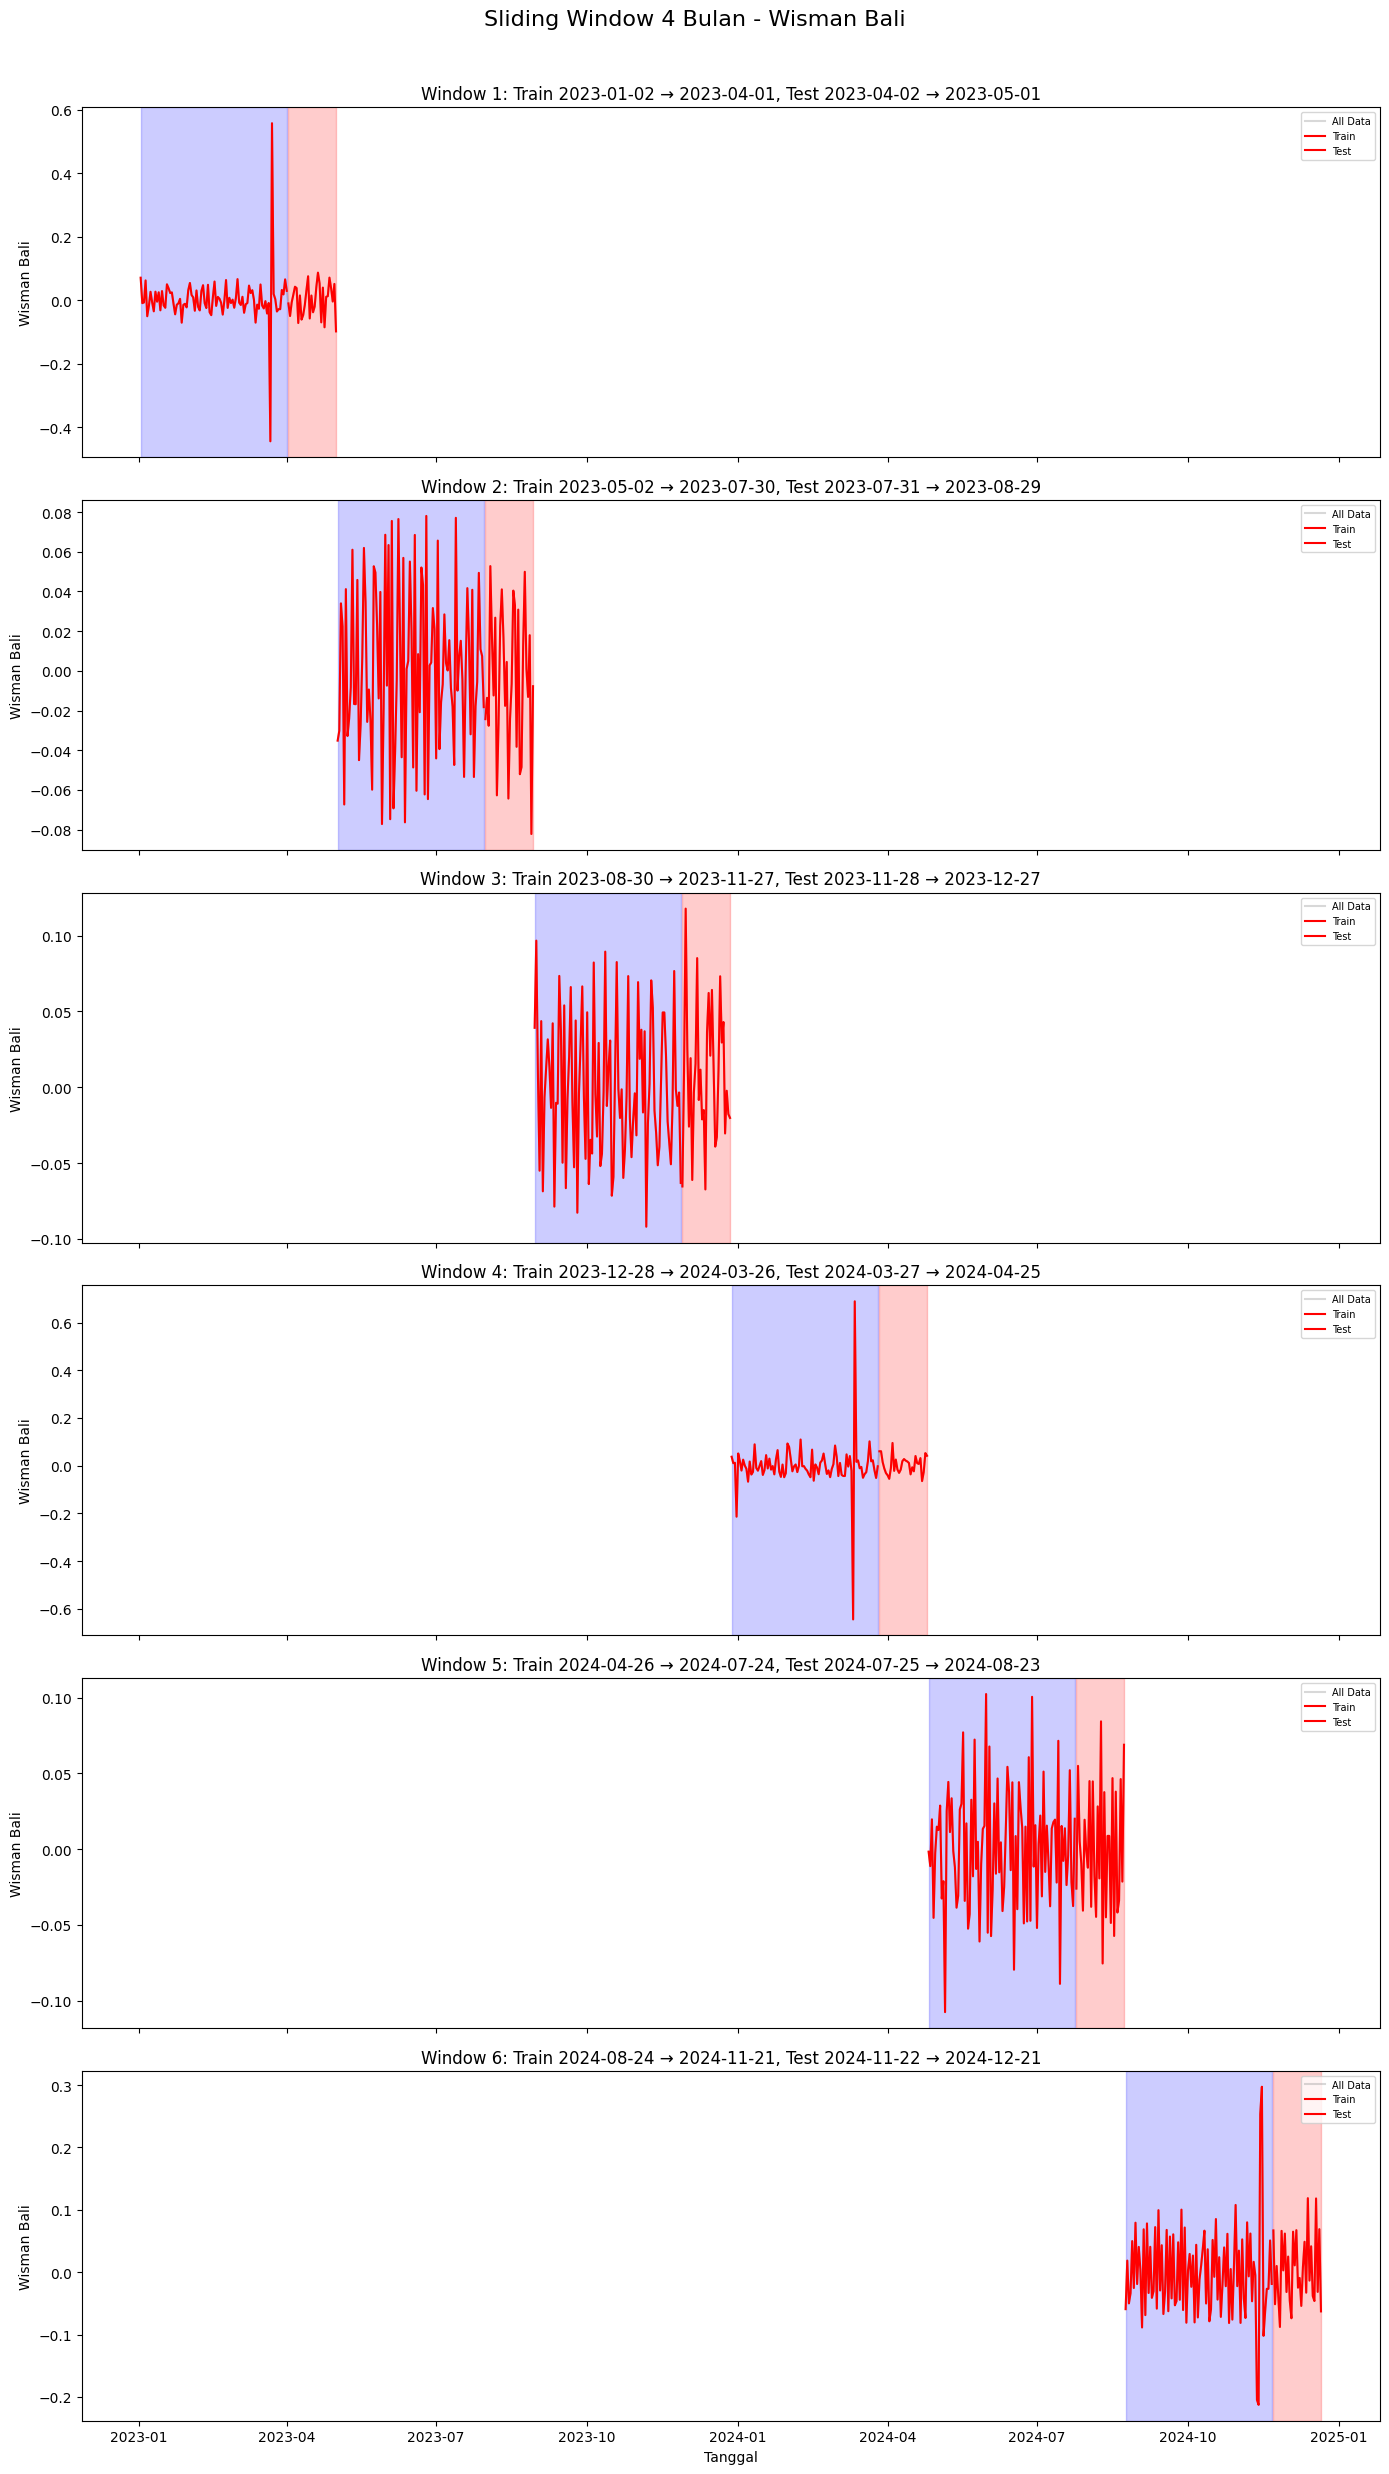

In [59]:
# Parameter sliding window
window_size = 120       # 4 bulan
n_test = 30             # 1 bulan test
n_train = window_size - n_test  # 3 bulan train
shift = 120             # geser per 4 bulan
n_windows = 6
n_total = len(df_norm_diff)

def plot_windows(df, var, color, label):
    fig, axes = plt.subplots(n_windows, 1, figsize=(14, 26), sharex=True)

    for i in range(n_windows):
        start, end = i * shift, i * shift + window_size
        if end > n_total:
            print(f"Window {i+1} out of bounds.")
            break

        window_data = df.iloc[start:end]
        train = window_data.iloc[:n_train]
        test = window_data.iloc[n_train:]
        ax = axes[i]

        ax.plot(window_data.index, window_data[var], color='gray', alpha=0.3, label='All Data')
        ax.axvspan(train.index[0], train.index[-1], color='blue', alpha=0.2)
        ax.axvspan(test.index[0], test.index[-1], color='red', alpha=0.2)
        ax.plot(train.index, train[var], color=color, label='Train')
        ax.plot(test.index, test[var], color=color, label='Test')

        ax.set_title(f"Window {i+1}: Train {train.index[0].date()} → {train.index[-1].date()}, Test {test.index[0].date()} → {test.index[-1].date()}")
        ax.set_ylabel(label)
        ax.legend(loc='upper right', fontsize=7)

    plt.xlabel("Tanggal")
    plt.suptitle(f"Sliding Window 4 Bulan - {label}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# Plot masing-masing variabel
plot_windows(df_norm_diff, 'Kurs', 'blue', 'Kurs')
plot_windows(df_norm_diff, 'Wisman Bali', 'red', 'Wisman Bali')


In [60]:
endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Raya']

# Sliding window 4 bulan: 3 bulan train (90), 1 bulan test (30)
window_size = 120
n_train = 90
n_test = 30
shift = 120
n_windows = 6
n_total = len(df_norm_diff)

for i in range(n_windows):
    start = i * shift
    end = start + window_size
    if end > n_total:
        print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
        break

    window_data = df_norm_diff.iloc[start:end]
    train = window_data.iloc[:n_train]
    test = window_data.iloc[n_train:]

    # Cari lag optimal (1 sampai 15)
    lag_selection = []
    for lag in range(1, 16):
        try:
            model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(lag, 0))
            results = model.fit(disp=False)
            lag_selection.append({
                'Lag': lag,
                'AIC': results.aic,
                'BIC': results.bic
            })
        except Exception as e:
            print(f"Error pada lag {lag} di Window {i+1}: {e}")
            continue

    df_lag = pd.DataFrame(lag_selection)
    print(f"\nWindow {i+1} - Evaluasi Lag:\n{df_lag}")

    if df_lag.empty:
        print(f"Window {i+1}: Tidak ada model yang berhasil difit.")
        continue

    # Pilih lag terbaik (berdasarkan AIC terkecil)
    best_idx = df_lag['AIC'].idxmin()
    best_order = int(df_lag.loc[best_idx, 'Lag'])

    # Fit model akhir
    best_model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(best_order, 0)).fit(disp=False)
    print(f"\nWindow {i+1} | Best Lag: {best_order} | AIC: {best_model.aic:.2f}")
    print(best_model.summary())


Window 1 - Evaluasi Lag:
    Lag         AIC         BIC
0     1 -565.861758 -538.363851
1     2 -562.305204 -524.808059
2     3 -560.996398 -513.500014
3     4 -555.498547 -498.002924
4     5 -554.640292 -487.145431
5     6 -553.154419 -475.660319
6     7 -546.626838 -459.133499
7     8 -541.690762 -444.198184
8     9 -535.735969 -428.244153
9    10 -532.909729 -415.418674
10   11 -532.197870 -404.707577
11   12 -529.249731 -391.760199
12   13 -526.857318 -379.368548
13   14 -518.950437 -361.462427
14   15 -510.450530 -342.963282

Window 1 | Best Lag: 1 | AIC: -565.86
                              Statespace Model Results                             
Dep. Variable:     ['Kurs', 'Wisman Bali']   No. Observations:                   90
Model:                             VARX(1)   Log Likelihood                 293.931
                               + intercept   AIC                           -565.862
Date:                     Fri, 11 Apr 2025   BIC                           -538.364
Tim

Lag 1

In [61]:
endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Raya']

# Parameter sliding window 4 bulan
window_size = 120        # 4 bulan data
n_test = 30             # 1 bulan test
n_train = window_size - n_test  # 3 bulan train
shift = 120              # geser per 4 bulan
n_windows1 = 6
n_total = len(df_norm)

mape_kurs_scores = []
mape_wisman_scores = []

for i in range(n_windows1):
    start = i * shift
    end = start + window_size
    if end > n_total:
        print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
        break

    window_data = df_norm.iloc[start:end]
    train = window_data.iloc[:n_train]
    test = window_data.iloc[n_train:]

    try:
        model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(1, 0))
        best_model = model.fit(disp=False)
        print(f"\nWindow {i+1} | Lag: 1 | AIC: {best_model.aic:.2f}")
        print(best_model.summary())

        # Forecast (masih dalam bentuk normalisasi)
        forecast_norm = best_model.forecast(steps=n_test, exog=test[exog_vars])

        # Denormalisasi forecast dan test data
        forecast_denorm = pd.DataFrame(scaler.inverse_transform(forecast_norm),
                                       columns=endog_vars, index=test.index)
        test_denorm = pd.DataFrame(scaler.inverse_transform(test[endog_vars]),
                                   columns=endog_vars, index=test.index)

        # Ambil nilai terakhir dari training data asli (bukan differenced)
        last_actual = df[endog_vars].iloc[start + n_train - 1]

        # Reverse differencing forecast
        forecast_reversed = forecast_denorm.copy()
        for col in endog_vars:
            forecast_reversed[col] = forecast_denorm[col].cumsum() + last_actual[col]

        # Reverse juga untuk test
        test_reversed = test_denorm.copy()
        for col in endog_vars:
            base = df[endog_vars][col].iloc[start + n_train - 1]
            test_reversed[col] = test_denorm[col].cumsum() + base

        # Hitung MAPE setelah reverse differencing
        mape_kurs = mean_absolute_percentage_error(test_reversed['Kurs'], forecast_reversed['Kurs'])
        mape_wisman = mean_absolute_percentage_error(test_reversed['Wisman Bali'], forecast_reversed['Wisman Bali'])

        mape_kurs_scores.append(mape_kurs)
        mape_wisman_scores.append(mape_wisman)

        print(f"Window {i+1} MAPE Kurs: {mape_kurs:.4f}, MAPE Wisman: {mape_wisman:.4f}")

    except Exception as e:
        print(f"Error pada Window {i+1}: {e}")
        continue

# Rata-rata MAPE akhir
if mape_kurs_scores and mape_wisman_scores:
    final_mape_kurs = np.mean(mape_kurs_scores)
    final_mape_wisman = np.mean(mape_wisman_scores)
    print(f"\nFinal Average MAPE Kurs: {final_mape_kurs:.4f}")
    print(f"Final Average MAPE Wisman: {final_mape_wisman:.4f}")


Window 1 | Lag: 1 | AIC: -580.18
                              Statespace Model Results                             
Dep. Variable:     ['Kurs', 'Wisman Bali']   No. Observations:                   90
Model:                             VARX(1)   Log Likelihood                 301.088
                               + intercept   AIC                           -580.176
Date:                     Fri, 11 Apr 2025   BIC                           -552.678
Time:                             14:18:01   HQIC                          -569.087
Sample:                         01-01-2023                                         
                              - 03-31-2023                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.18, 0.28   Jarque-Bera (JB):       44.09, 3616.11
Prob(Q):                        0.67, 0.60   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.47, 6.30

Lag 6

In [62]:
endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Raya']

# Parameter sliding window 4 bulan
window_size = 120        # 4 bulan data
n_test = 30             # 1 bulan test
n_train = window_size - n_test  # 3 bulan train
shift = 120              # geser per 4 bulan
n_windows1 = 6
n_total = len(df_norm)

mape_kurs_scores = []
mape_wisman_scores = []

for i in range(n_windows1):
    start = i * shift
    end = start + window_size
    if end > n_total:
        print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
        break

    window_data = df_norm.iloc[start:end]
    train = window_data.iloc[:n_train]
    test = window_data.iloc[n_train:]

    try:
        model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(6, 0))
        best_model = model.fit(disp=False)
        print(f"\nWindow {i+1} | Lag: 6 | AIC: {best_model.aic:.2f}")
        print(best_model.summary())

        # Forecast (masih dalam bentuk normalisasi)
        forecast_norm = best_model.forecast(steps=n_test, exog=test[exog_vars])

        # Denormalisasi forecast dan test data
        forecast_denorm = pd.DataFrame(scaler.inverse_transform(forecast_norm),
                                       columns=endog_vars, index=test.index)
        test_denorm = pd.DataFrame(scaler.inverse_transform(test[endog_vars]),
                                   columns=endog_vars, index=test.index)

        # Ambil nilai terakhir dari training data asli (bukan differenced)
        last_actual = df[endog_vars].iloc[start + n_train - 1]

        # Reverse differencing forecast
        forecast_reversed = forecast_denorm.copy()
        for col in endog_vars:
            forecast_reversed[col] = forecast_denorm[col].cumsum() + last_actual[col]

        # Reverse juga untuk test
        test_reversed = test_denorm.copy()
        for col in endog_vars:
            base = df[endog_vars][col].iloc[start + n_train - 1]
            test_reversed[col] = test_denorm[col].cumsum() + base

        # Hitung MAPE setelah reverse differencing
        mape_kurs = mean_absolute_percentage_error(test_reversed['Kurs'], forecast_reversed['Kurs'])
        mape_wisman = mean_absolute_percentage_error(test_reversed['Wisman Bali'], forecast_reversed['Wisman Bali'])

        mape_kurs_scores.append(mape_kurs)
        mape_wisman_scores.append(mape_wisman)

        print(f"Window {i+1} MAPE Kurs: {mape_kurs:.4f}, MAPE Wisman: {mape_wisman:.4f}")

    except Exception as e:
        print(f"Error pada Window {i+1}: {e}")
        continue

# Rata-rata MAPE akhir
if mape_kurs_scores and mape_wisman_scores:
    final_mape_kurs = np.mean(mape_kurs_scores)
    final_mape_wisman = np.mean(mape_wisman_scores)
    print(f"\nFinal Average MAPE Kurs: {final_mape_kurs:.4f}")
    print(f"Final Average MAPE Wisman: {final_mape_wisman:.4f}")


Window 1 | Lag: 6 | AIC: -548.43
                              Statespace Model Results                             
Dep. Variable:     ['Kurs', 'Wisman Bali']   No. Observations:                   90
Model:                             VARX(6)   Log Likelihood                 305.213
                               + intercept   AIC                           -548.427
Date:                     Fri, 11 Apr 2025   BIC                           -470.933
Time:                             14:18:10   HQIC                          -517.177
Sample:                         01-01-2023                                         
                              - 03-31-2023                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             2.57, 0.13   Jarque-Bera (JB):       43.09, 3757.71
Prob(Q):                        0.11, 0.72   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.29, 6.31

#####**6 Bulan**

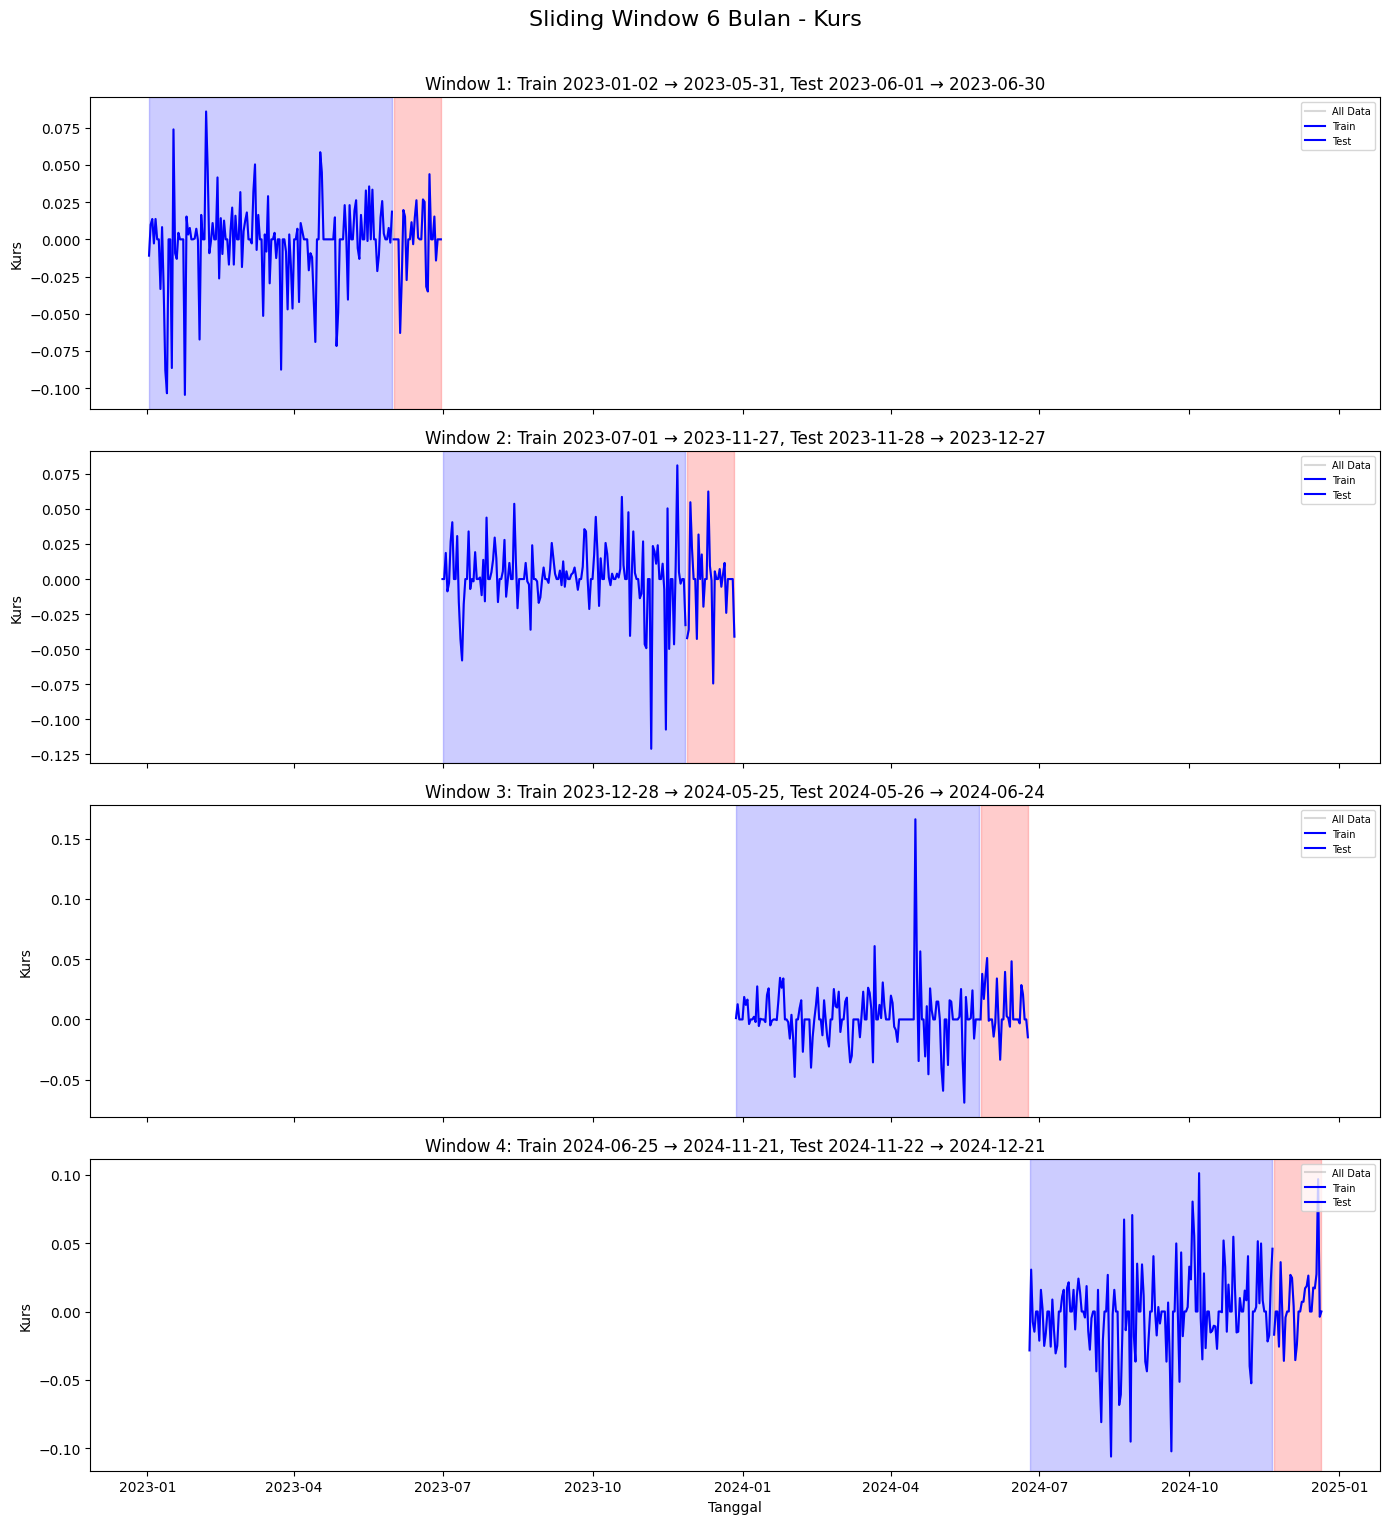

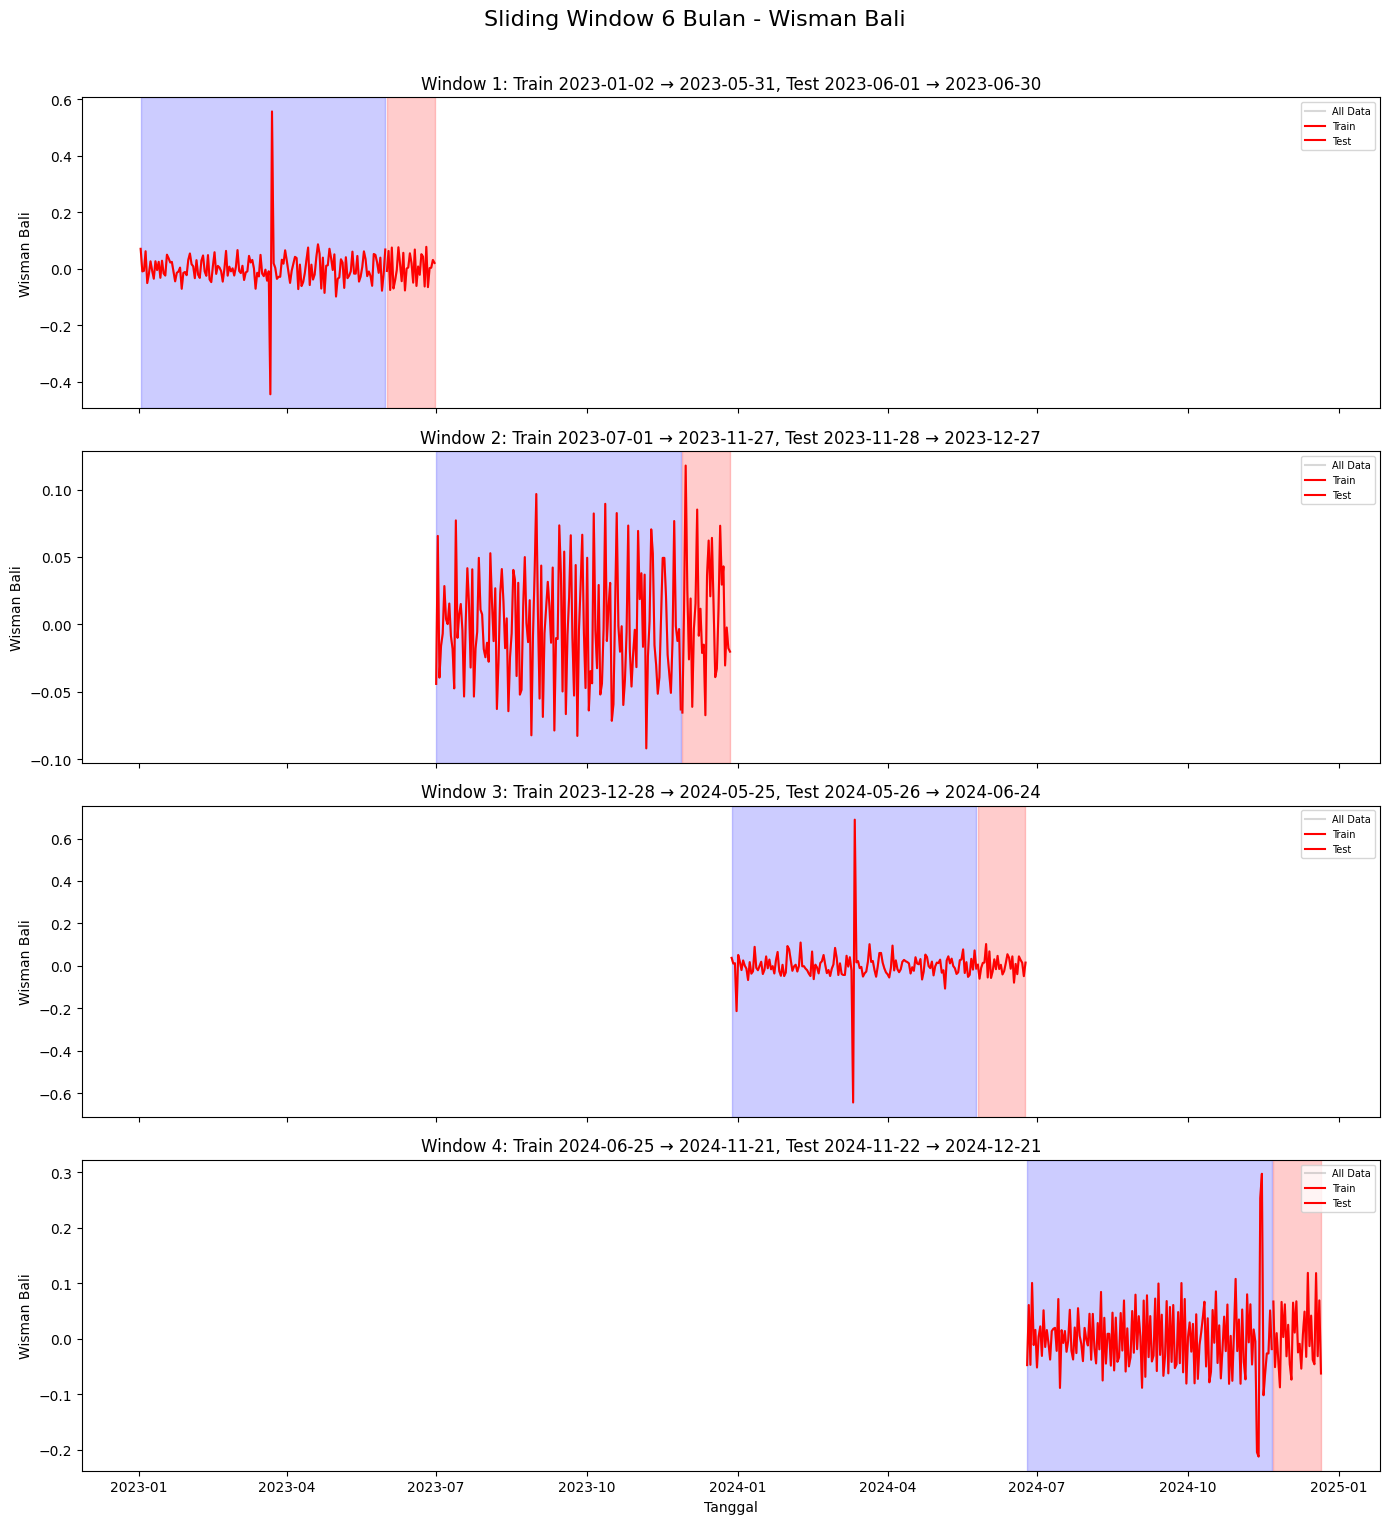

In [63]:
# Parameter sliding window
window_size = 180       # 6 bulan
n_test = 30             # 1 bulan test
n_train = window_size - n_test  # 5 bulan train
shift = 180            # geser per 6 bulan
n_windows = 4
n_total = len(df_norm_diff)

def plot_windows(df, var, color, label):
    fig, axes = plt.subplots(n_windows, 1, figsize=(14, 16), sharex=True)

    for i in range(n_windows):
        start, end = i * shift, i * shift + window_size
        if end > n_total:
            print(f"Window {i+1} out of bounds.")
            break

        window_data = df.iloc[start:end]
        train = window_data.iloc[:n_train]
        test = window_data.iloc[n_train:]
        ax = axes[i]

        ax.plot(window_data.index, window_data[var], color='gray', alpha=0.3, label='All Data')
        ax.axvspan(train.index[0], train.index[-1], color='blue', alpha=0.2)
        ax.axvspan(test.index[0], test.index[-1], color='red', alpha=0.2)
        ax.plot(train.index, train[var], color=color, label='Train')
        ax.plot(test.index, test[var], color=color, label='Test')

        ax.set_title(f"Window {i+1}: Train {train.index[0].date()} → {train.index[-1].date()}, Test {test.index[0].date()} → {test.index[-1].date()}")
        ax.set_ylabel(label)
        ax.legend(loc='upper right', fontsize=7)

    plt.xlabel("Tanggal")
    plt.suptitle(f"Sliding Window 6 Bulan - {label}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# Plot masing-masing variabel
plot_windows(df_norm_diff, 'Kurs', 'blue', 'Kurs')
plot_windows(df_norm_diff, 'Wisman Bali', 'red', 'Wisman Bali')

In [64]:
from statsmodels.tsa.statespace.varmax import VARMAX

endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Raya']

# Sliding window 6 bulan: 5 bulan train (150), 1 bulan test (30)
window_size = 180
n_train = 150
n_test = 30
shift = 180
n_windows = 4
n_total = len(df_norm_diff)

for i in range(n_windows):
    start = i * shift
    end = start + window_size
    if end > n_total:
        print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
        break

    window_data = df_norm_diff.iloc[start:end]
    train = window_data.iloc[:n_train]
    test = window_data.iloc[n_train:]

    # Cari lag optimal (1 sampai 15)
    lag_selection = []
    for lag in range(1, 16):
        try:
            model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(lag, 0))
            results = model.fit(disp=False)
            lag_selection.append({
                'Lag': lag,
                'AIC': results.aic,
                'BIC': results.bic
            })
        except Exception as e:
            print(f"Error pada lag {lag} di Window {i+1}: {e}")
            continue

    df_lag = pd.DataFrame(lag_selection)
    print(f"\nWindow {i+1} - Evaluasi Lag:\n{df_lag}")

    if df_lag.empty:
        print(f"Window {i+1}: Tidak ada model yang berhasil difit.")
        continue

    # Pilih lag terbaik (berdasarkan AIC terkecil)
    best_idx = df_lag['AIC'].idxmin()
    best_order = int(df_lag.loc[best_idx, 'Lag'])

    # Fit model akhir
    best_model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(best_order, 0)).fit(disp=False)
    print(f"\nWindow {i+1} | Best Lag: {best_order} | AIC: {best_model.aic:.2f}")
    print(best_model.summary())



Window 1 - Evaluasi Lag:
    Lag          AIC         BIC
0     1 -1025.664894 -992.547906
1     2 -1023.033818 -977.874288
2     3 -1023.257179 -966.055108
3     4 -1021.226750 -951.982138
4     5 -1025.060246 -943.773093
5     6 -1028.503662 -935.173968
6     7 -1022.174355 -916.802120
7     8 -1018.288348 -900.873571
8     9 -1014.173889 -884.716571
9    10 -1009.290877 -867.791018
10   11 -1012.124183 -858.581783
11   12 -1010.769522 -845.184581
12   13 -1008.269920 -830.642438
13   14 -1005.621426 -815.951403
14   15  -999.021810 -797.309245

Window 1 | Best Lag: 6 | AIC: -1028.50
                              Statespace Model Results                             
Dep. Variable:     ['Kurs', 'Wisman Bali']   No. Observations:                  150
Model:                             VARX(6)   Log Likelihood                 545.252
                               + intercept   AIC                          -1028.504
Date:                     Fri, 11 Apr 2025   BIC                      

Lag 6

In [65]:
endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Raya']

# Parameter sliding window 6 bulan
window_size = 180        # 6 bulan data
n_test = 30             # 1 bulan test
n_train = window_size - n_test  # 5 bulan train
shift = 180              # geser per 6 bulan
n_windows1 = 8
n_total = len(df_norm)

mape_kurs_scores = []
mape_wisman_scores = []

for i in range(n_windows1):
    start = i * shift
    end = start + window_size
    if end > n_total:
        print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
        break

    window_data = df_norm.iloc[start:end]
    train = window_data.iloc[:n_train]
    test = window_data.iloc[n_train:]

    try:
        model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(6, 0))
        best_model = model.fit(disp=False)
        print(f"\nWindow {i+1} | Lag: 6 | AIC: {best_model.aic:.2f}")
        print(best_model.summary())

        # Forecast (masih dalam bentuk normalisasi)
        forecast_norm = best_model.forecast(steps=n_test, exog=test[exog_vars])

        # Denormalisasi forecast dan test data
        forecast_denorm = pd.DataFrame(scaler.inverse_transform(forecast_norm),
                                       columns=endog_vars, index=test.index)
        test_denorm = pd.DataFrame(scaler.inverse_transform(test[endog_vars]),
                                   columns=endog_vars, index=test.index)

        # Ambil nilai terakhir dari training data asli (bukan differenced)
        last_actual = df[endog_vars].iloc[start + n_train - 1]

        # Reverse differencing forecast
        forecast_reversed = forecast_denorm.copy()
        for col in endog_vars:
            forecast_reversed[col] = forecast_denorm[col].cumsum() + last_actual[col]

        # Reverse juga untuk test
        test_reversed = test_denorm.copy()
        for col in endog_vars:
            base = df[endog_vars][col].iloc[start + n_train - 1]
            test_reversed[col] = test_denorm[col].cumsum() + base

        # Hitung MAPE setelah reverse differencing
        mape_kurs = mean_absolute_percentage_error(test_reversed['Kurs'], forecast_reversed['Kurs'])
        mape_wisman = mean_absolute_percentage_error(test_reversed['Wisman Bali'], forecast_reversed['Wisman Bali'])

        mape_kurs_scores.append(mape_kurs)
        mape_wisman_scores.append(mape_wisman)

        print(f"Window {i+1} MAPE Kurs: {mape_kurs:.4f}, MAPE Wisman: {mape_wisman:.4f}")

    except Exception as e:
        print(f"Error pada Window {i+1}: {e}")
        continue

# Rata-rata MAPE akhir
if mape_kurs_scores and mape_wisman_scores:
    final_mape_kurs = np.mean(mape_kurs_scores)
    final_mape_wisman = np.mean(mape_wisman_scores)
    print(f"\nFinal Average MAPE Kurs: {final_mape_kurs:.4f}")
    print(f"Final Average MAPE Wisman: {final_mape_wisman:.4f}")


Window 1 | Lag: 6 | AIC: -1018.67
                              Statespace Model Results                             
Dep. Variable:     ['Kurs', 'Wisman Bali']   No. Observations:                  150
Model:                             VARX(6)   Log Likelihood                 540.336
                               + intercept   AIC                          -1018.672
Date:                     Fri, 11 Apr 2025   BIC                           -925.342
Time:                             14:34:32   HQIC                          -980.755
Sample:                         01-01-2023                                         
                              - 05-30-2023                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.21, 0.00   Jarque-Bera (JB):       45.53, 5973.79
Prob(Q):                        0.64, 0.99   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.48, 1.3

Lag 8

In [66]:
endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Raya']

# Parameter sliding window 6 bulan
window_size = 180        # 6 bulan data
n_test = 30             # 1 bulan test
n_train = window_size - n_test  # 5 bulan train
shift = 180              # geser per 6 bulan
n_windows1 = 8
n_total = len(df_norm)

mape_kurs_scores = []
mape_wisman_scores = []

for i in range(n_windows1):
    start = i * shift
    end = start + window_size
    if end > n_total:
        print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
        break

    window_data = df_norm.iloc[start:end]
    train = window_data.iloc[:n_train]
    test = window_data.iloc[n_train:]

    try:
        model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(8, 0))
        best_model = model.fit(disp=False)
        print(f"\nWindow {i+1} | Lag: 8 | AIC: {best_model.aic:.2f}")
        print(best_model.summary())

        # Forecast (masih dalam bentuk normalisasi)
        forecast_norm = best_model.forecast(steps=n_test, exog=test[exog_vars])

        # Denormalisasi forecast dan test data
        forecast_denorm = pd.DataFrame(scaler.inverse_transform(forecast_norm),
                                       columns=endog_vars, index=test.index)
        test_denorm = pd.DataFrame(scaler.inverse_transform(test[endog_vars]),
                                   columns=endog_vars, index=test.index)

        # Ambil nilai terakhir dari training data asli (bukan differenced)
        last_actual = df[endog_vars].iloc[start + n_train - 1]

        # Reverse differencing forecast
        forecast_reversed = forecast_denorm.copy()
        for col in endog_vars:
            forecast_reversed[col] = forecast_denorm[col].cumsum() + last_actual[col]

        # Reverse juga untuk test
        test_reversed = test_denorm.copy()
        for col in endog_vars:
            base = df[endog_vars][col].iloc[start + n_train - 1]
            test_reversed[col] = test_denorm[col].cumsum() + base

        # Hitung MAPE setelah reverse differencing
        mape_kurs = mean_absolute_percentage_error(test_reversed['Kurs'], forecast_reversed['Kurs'])
        mape_wisman = mean_absolute_percentage_error(test_reversed['Wisman Bali'], forecast_reversed['Wisman Bali'])

        mape_kurs_scores.append(mape_kurs)
        mape_wisman_scores.append(mape_wisman)

        print(f"Window {i+1} MAPE Kurs: {mape_kurs:.4f}, MAPE Wisman: {mape_wisman:.4f}")

    except Exception as e:
        print(f"Error pada Window {i+1}: {e}")
        continue

# Rata-rata MAPE akhir
if mape_kurs_scores and mape_wisman_scores:
    final_mape_kurs = np.mean(mape_kurs_scores)
    final_mape_wisman = np.mean(mape_wisman_scores)
    print(f"\nFinal Average MAPE Kurs: {final_mape_kurs:.4f}")
    print(f"Final Average MAPE Wisman: {final_mape_wisman:.4f}")


Window 1 | Lag: 8 | AIC: -1012.29
                              Statespace Model Results                             
Dep. Variable:     ['Kurs', 'Wisman Bali']   No. Observations:                  150
Model:                             VARX(8)   Log Likelihood                 545.146
                               + intercept   AIC                          -1012.292
Date:                     Fri, 11 Apr 2025   BIC                           -894.877
Time:                             14:35:01   HQIC                          -964.590
Sample:                         01-01-2023                                         
                              - 05-30-2023                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.42, 0.03   Jarque-Bera (JB):       62.16, 5966.73
Prob(Q):                        0.52, 0.86   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.46, 1.2